In [605]:
import pandas as pd
import numpy as np
import os, time, stat, io
from scipy.stats import gamma, norm
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('fivethirtyeight')
import plotly.io as pio

%load_ext autoreload
%autoreload 2
from covid_data_helper import *
from coronita_chart_helper import *
from coronita_model_helper import *
from coronita_web_helper import *

from matplotlib.backends.backend_pdf import PdfPages


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Ingestion

## Bring in State Data

In [110]:
df_st_testing = get_covid19_tracking_data()
df_st_testing.loc[['NY']].tail()

State Testing Data Last Observation:  20200707


date  positive   negative  pending  \
code dt                                                   
NY   2020-07-03  20200703  395872.0  3712113.0      NaN   
     2020-07-04  20200704  396598.0  3773790.0      NaN   
     2020-07-05  20200705  397131.0  3836672.0      NaN   
     2020-07-06  20200706  397649.0  3890482.0      NaN   
     2020-07-07  20200707  398237.0  3946630.0      NaN   

                 hospitalizedCurrently  hospitalizedCumulative  \
code dt                                                          
NY   2020-07-03                  857.0                 89995.0   
     2020-07-04                  844.0                 89995.0   
     2020-07-05                  832.0                 89995.0   
     2020-07-06                  817.0                 89995.0   
     2020-07-07                  836.0                 89995.0   

                 inIcuCurrently  inIcuCumulative  onVentilatorCurrently  \
code dt                                                                   
NY   2020-07-03           188.0              NaN                  125.0   
     2020-07-04           190.0              NaN                  119.0   
     2020-07-05           178.0              NaN                  116.0   
     2020-07-06           170.0              NaN                  103.0   
     2020-07-07           160.0              NaN                  103.0   

                 onVentilatorCumulative  ...   posNeg deathIncrease  \
code dt                                  ...                          
NY   2020-07-03                     NaN  ...  4107985             8   
     2020-07-04                     NaN  ...  4170388            11   
     2020-07-05                     NaN  ...  4233803             8   
     2020-07-06                     NaN  ...  4288131             9   
     2020-07-07                     NaN  ...  4344867            11   

                hospitalizedIncrease  \
code dt                                
NY   2020-07-03                    0   
     2020-07-04                    0   
     2020-07-05                    0   
     2020-07-06                    0   
     2020-07-07                    0   

                                                     hash commercialScore  \
code dt                                                                     
NY   2020-07-03  6bf505e26be3f1cd6e0ffa88eb3f85864b177b7e               0   
     2020-07-04  cdea554b3269e7cb8187a1a5c365272483900662               0   
     2020-07-05  1c5afdff7b2fa69f33845a746e76693738e8d3be               0   
     2020-07-06  c6888dc84ffdd4847e653b21f88103eec85272c1               0   
     2020-07-07  2b2a225f8b63f528dea6f828c18cf73038539e2f               0   

                 negativeRegularScore  negativeScore positiveScore  score  \
code dt                                                                     
NY   2020-07-03                     0              0             0      0   
     2020-07-04                     0              0             0      0   
     2020-07-05                     0              0             0      0   
     2020-07-06                     0              0             0      0   
     2020-07-07                     0              0             0      0   

                 grade  
code dt                 
NY   2020-07-03    NaN  
     2020-07-04    NaN  
     2020-07-05    NaN  
     2020-07-06    NaN  
     2020-07-07    NaN  

[5 rows x 38 columns]

In [111]:
df_st_testing.dateChecked

code  dt        
AK    2020-03-06                     NaN
      2020-03-07                     NaN
      2020-03-08                     NaN
      2020-03-09                     NaN
      2020-03-10                     NaN
                            ...         
WY    2020-07-03    2020-07-03T11:24:00Z
      2020-07-04    2020-07-04T12:20:00Z
      2020-07-05    2020-07-05T13:36:00Z
      2020-07-06    2020-07-05T13:36:00Z
      2020-07-07    2020-07-07T17:47:00Z
Name: dateChecked, Length: 6961, dtype: object

In [112]:
df_census = get_census_pop()
df_census.head()

state   county   fips  SUMLEV  REGION  DIVISION  pop2019
0    AL  Alabama  01000      40       3         6  4903185
1    AL  Autauga  01001      50       3         6    55869
2    AL  Baldwin  01003      50       3         6   223234
3    AL  Barbour  01005      50       3         6    24686
4    AL     Bibb  01007      50       3         6    22394

In [113]:
df_counties = get_complete_county_data() #get_nyt_counties()
df_counties.head()

pop2019  cases  deaths  cases_per100k  \
dt         state county    fips                                             
2020-01-21 WA    Snohomish 53061   822083.0    1.0     0.0       0.121642   
2020-01-22 WA    Snohomish 53061   822083.0    1.0     0.0       0.121642   
2020-01-23 WA    Snohomish 53061   822083.0    1.0     0.0       0.121642   
2020-01-24 IL    Cook      17031  5150233.0    1.0     0.0       0.019417   
           WA    Snohomish 53061   822083.0    1.0     0.0       0.121642   

                                  retail_and_recreation_percent_change_from_baseline  \
dt         state county    fips                                                        
2020-01-21 WA    Snohomish 53061                                                NaN    
2020-01-22 WA    Snohomish 53061                                                NaN    
2020-01-23 WA    Snohomish 53061                                                NaN    
2020-01-24 IL    Cook      17031                                                NaN    
           WA    Snohomish 53061                                                NaN    

                                  grocery_and_pharmacy_percent_change_from_baseline  \
dt         state county    fips                                                       
2020-01-21 WA    Snohomish 53061                                                NaN   
2020-01-22 WA    Snohomish 53061                                                NaN   
2020-01-23 WA    Snohomish 53061                                                NaN   
2020-01-24 IL    Cook      17031                                                NaN   
           WA    Snohomish 53061                                                NaN   

                                  parks_percent_change_from_baseline  \
dt         state county    fips                                        
2020-01-21 WA    Snohomish 53061                                 NaN   
2020-01-22 WA    Snohomish 53061                                 NaN   
2020-01-23 WA    Snohomish 53061                                 NaN   
2020-01-24 IL    Cook      17031                                 NaN   
           WA    Snohomish 53061                                 NaN   

                                  transit_stations_percent_change_from_baseline  \
dt         state county    fips                                                   
2020-01-21 WA    Snohomish 53061                                            NaN   
2020-01-22 WA    Snohomish 53061                                            NaN   
2020-01-23 WA    Snohomish 53061                                            NaN   
2020-01-24 IL    Cook      17031                                            NaN   
           WA    Snohomish 53061                                            NaN   

                                  workplaces_percent_change_from_baseline  \
dt         state county    fips                                             
2020-01-21 WA    Snohomish 53061                                      NaN   
2020-01-22 WA    Snohomish 53061                                      NaN   
2020-01-23 WA    Snohomish 53061                                      NaN   
2020-01-24 IL    Cook      17031                                      NaN   
           WA    Snohomish 53061                                      NaN   

                                  residential_percent_change_from_baseline  
dt         state county    fips                                             
2020-01-21 WA    Snohomish 53061                                       NaN  
2020-01-22 WA    Snohomish 53061                                       NaN  
2020-01-23 WA    Snohomish 53061                                       NaN  
2020-01-24 IL    Cook      17031                                       NaN  
           WA    Snohomish 53061                                       NaN

In [114]:
counties_geo = get_counties_geo()


In [115]:
df_jhu_counties = get_jhu_counties()
df_jhu_counties.head()

cases  deaths
dt      state   county  fips                
1/22/20 Alabama Autauga 01001      0       0
                Baldwin 01003      0       0
                Barbour 01005      0       0
                Bibb    01007      0       0
                Blount  01009      0       0

In [116]:
# df_counties_enhanced = pd.merge(
#     df_census[df_census.SUMLEV==50], 
#     df_counties.loc[[(df_counties.index.levels[0][-1])]].reset_index()[['dt','fips','cases','deaths']], 
#     on='fips', how='left')
# df_counties_enhanced['cases_per100k']= df_counties_enhanced['cases'].mul(1e5).div(df_counties_enhanced['pop2019'])
# df_counties_enhanced.head()


In [117]:
df_st_testing_fmt = df_st_testing.copy()
df_st_testing_fmt = df_st_testing_fmt.rename(columns={'death':'deaths','positive':'cases'}).unstack('code')
df_st_testing_fmt.head()

date                                      ... grade              \
code         AK  AL  AR  AS  AZ  CA  CO  CT  DC  DE  ...    TN  TX  UT  VA   
dt                                                   ...                     
2020-01-22  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...   NaN NaN NaN NaN   
2020-01-23  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...   NaN NaN NaN NaN   
2020-01-24  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...   NaN NaN NaN NaN   
2020-01-25  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...   NaN NaN NaN NaN   
2020-01-26  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...   NaN NaN NaN NaN   

                                    
code        VI  VT  WA  WI  WV  WY  
dt                                  
2020-01-22 NaN NaN NaN NaN NaN NaN  
2020-01-23 NaN NaN NaN NaN NaN NaN  
2020-01-24 NaN NaN NaN NaN NaN NaN  
2020-01-25 NaN NaN NaN NaN NaN NaN  
2020-01-26 NaN NaN NaN NaN NaN NaN  

[5 rows x 2128 columns]

In [118]:
# df_interventions = pd.read_csv(
#     'https://docs.google.com/spreadsheets/d/e/2PACX-1vSu4im6FgHikhHPjjLFm69MJ36z7jTf30jKWaFZUmiCi9S5E2_YobVRc0NNnC35SwHOY8cznmSR0JcU/pub?gid=8197069&single=true&output=csv'
# )
# df_interventions.head()

df_interventions = get_state_policy_events()
df_interventions.head()


state state_code         dt                             all_dates  \
0  Alabama         AL 2020-03-13                      [3/13, 5/8, 7/2]   
1  Alabama         AL 2020-03-17  [3/17, 3/19, 3/20, 3/26, 3/27, 4/28]   
2  Alabama         AL 2020-03-18                                [3/18]   
3  Alabama         AL 2020-03-23                                [3/23]   
4  Alabama         AL 2020-03-27                           [3/27, 4/3]   

                                          event_name  \
0                            Public Health Emergency   
1  School Closures, Large Gatherings Ban, Bar/Res...   
2                      Primary Election Postponement   
3                                Section 1135 Waiver   
4  Non-Essential Business Closures, Stay At Home ...   

  social_distancing_direction  \
0                 restricting   
1                 restricting   
2                 restricting   
3                 restricting   
4                 restricting   

                                                urls  
0  https://governor.alabama.gov/newsroom/2020/03/...  
1  http://www.alabamapublichealth.gov/legal/asset...  
2  https://governor.alabama.gov/newsroom/2020/03/...  
3  https://www.medicaid.gov/state-resource-center...  
4  http://www.alabamapublichealth.gov/legal/asset...

In [119]:
df_goog_mob_us = get_goog_mvmt_us()
df_goog_mob_us = df_goog_mob_us[df_goog_mob_us.state.isnull()].set_index('dt')
df_goog_mob_us.head()

country_region_code country_region state county iso_3166_2_code  \
dt                                                                           
2020-02-15                  US  United States   NaN    NaN             NaN   
2020-02-16                  US  United States   NaN    NaN             NaN   
2020-02-17                  US  United States   NaN    NaN             NaN   
2020-02-18                  US  United States   NaN    NaN             NaN   
2020-02-19                  US  United States   NaN    NaN             NaN   

             fips  retail_and_recreation_percent_change_from_baseline  \
dt                                                                      
2020-02-15  00000                                                6.0    
2020-02-16  00000                                                7.0    
2020-02-17  00000                                                6.0    
2020-02-18  00000                                                0.0    
2020-02-19  00000                                                2.0    

            grocery_and_pharmacy_percent_change_from_baseline  \
dt                                                              
2020-02-15                                                2.0   
2020-02-16                                                1.0   
2020-02-17                                                0.0   
2020-02-18                                               -1.0   
2020-02-19                                                0.0   

            parks_percent_change_from_baseline  \
dt                                               
2020-02-15                                15.0   
2020-02-16                                16.0   
2020-02-17                                28.0   
2020-02-18                                 6.0   
2020-02-19                                 8.0   

            transit_stations_percent_change_from_baseline  \
dt                                                          
2020-02-15                                            3.0   
2020-02-16                                            2.0   
2020-02-17                                           -9.0   
2020-02-18                                            1.0   
2020-02-19                                            1.0   

            workplaces_percent_change_from_baseline  \
dt                                                    
2020-02-15                                      2.0   
2020-02-16                                      0.0   
2020-02-17                                    -24.0   
2020-02-18                                      0.0   
2020-02-19                                      1.0   

            residential_percent_change_from_baseline  
dt                                                    
2020-02-15                                      -1.0  
2020-02-16                                      -1.0  
2020-02-17                                       5.0  
2020-02-18                                       1.0  
2020-02-19                                       0.0

In [120]:
df_goog_mob_state = get_goog_mvmt_state()
df_goog_mob_state.head()

retail_and_recreation_percent_change_from_baseline  \
state dt                                                               
AL    2020-02-15                                                5.0    
      2020-02-16                                                0.0    
      2020-02-17                                                3.0    
      2020-02-18                                               -4.0    
      2020-02-19                                                4.0    

                  grocery_and_pharmacy_percent_change_from_baseline  \
state dt                                                              
AL    2020-02-15                                                2.0   
      2020-02-16                                               -2.0   
      2020-02-17                                                0.0   
      2020-02-18                                               -3.0   
      2020-02-19                                                1.0   

                  parks_percent_change_from_baseline  \
state dt                                               
AL    2020-02-15                                39.0   
      2020-02-16                                -7.0   
      2020-02-17                                17.0   
      2020-02-18                               -11.0   
      2020-02-19                                 6.0   

                  transit_stations_percent_change_from_baseline  \
state dt                                                          
AL    2020-02-15                                            7.0   
      2020-02-16                                            3.0   
      2020-02-17                                            7.0   
      2020-02-18                                           -1.0   
      2020-02-19                                            4.0   

                  workplaces_percent_change_from_baseline  \
state dt                                                    
AL    2020-02-15                                      2.0   
      2020-02-16                                     -1.0   
      2020-02-17                                    -17.0   
      2020-02-18                                      1.0   
      2020-02-19                                      1.0   

                  residential_percent_change_from_baseline  
state dt                                                    
AL    2020-02-15                                      -1.0  
      2020-02-16                                       1.0  
      2020-02-17                                       4.0  
      2020-02-18                                       2.0  
      2020-02-19                                       0.0

In [121]:
covid_params = {}
covid_params['d_incub'] = 3.
covid_params['d_infect'] = 4.
covid_params['mort_rt'] = 0.01
covid_params['d_in_hosp'] = 11
covid_params['hosp_rt'] = 0.04
covid_params['d_to_hosp'] = 7.0
covid_params['d_in_hosp_mild'] = 11.0
covid_params['icu_rt'] = 13./41.
covid_params['d_in_icu'] = 13.0
covid_params['vent_rt'] = 0.4
covid_params['d_til_death'] =  17.0
covid_params['policy_trigger'] = True
covid_params['policy_trigger_once'] = True


# Data Exploration

                  metric
weighted_average  rt        1.329243
                  rt_l68    1.078465
                  rt_l95    0.837718
                  rt_u68    1.580021
                  rt_u95    1.820768
Name: 2020-06-23 00:00:00, dtype: float64

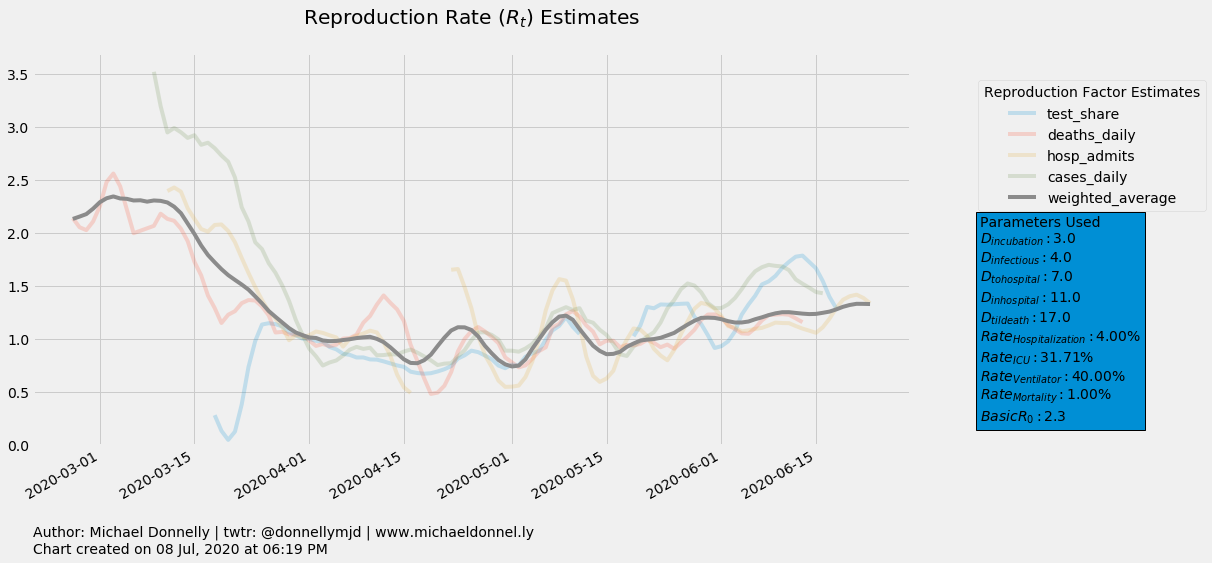

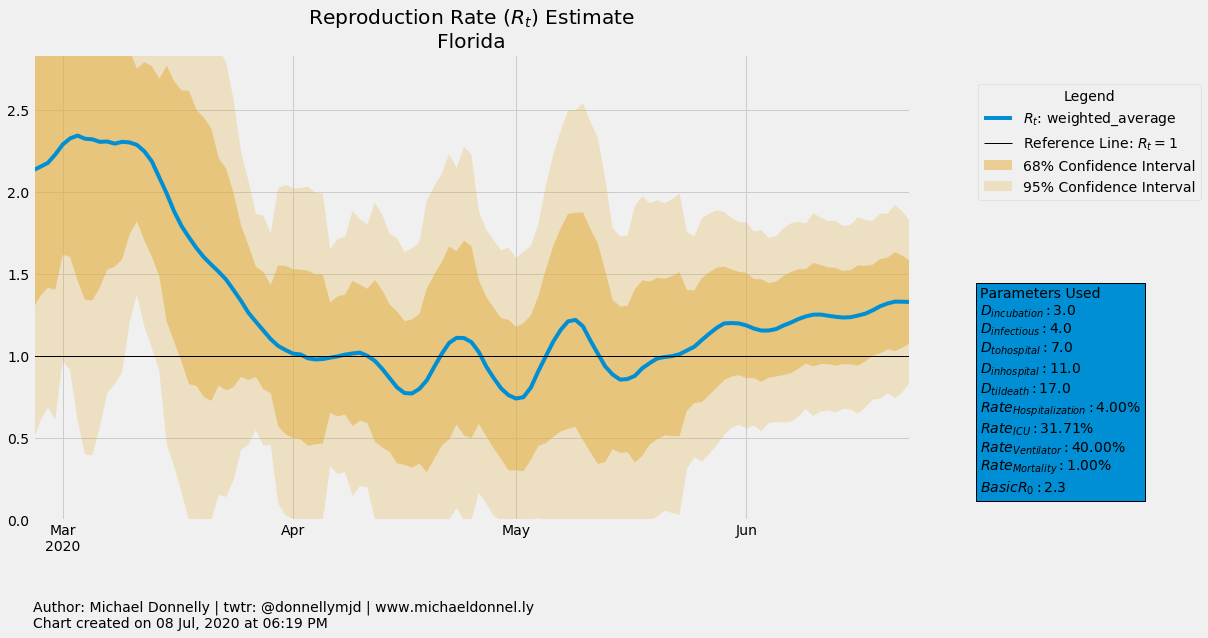

In [122]:
state= 'FL'
model_dict = make_model_dict_state(state, abbrev_us_state, df_census, df_st_testing_fmt, covid_params, 150)

display(model_dict['df_rts_conf'][['weighted_average']].unstack('metric').iloc[-1])
ch_rts(model_dict, param_str_maker(model_dict))
plt.show()
ax = ch_rt_confid(model_dict['df_rts_conf'][['weighted_average']].unstack('metric'), 
             param_str_maker(model_dict), model_dict['region_name'])
# model_dict['df_rts'].plot(ax=ax, linewidth=1.0)

# Scenarios

In [123]:
df_rts_allregs = pd.DataFrame()
df_wavg_rt_conf_allregs = pd.DataFrame()

for region in df_st_testing_fmt['date'].columns:
    try:
        model_dict = make_model_dict_state(region, abbrev_us_state, df_census, df_st_testing_fmt, covid_params, 150)
        
        this_reg_df_rts = pd.DataFrame(model_dict['df_rts'].stack(), columns=[region])
        this_reg_df_wavg = pd.DataFrame(
            model_dict['df_rts_conf'].sort_index().unstack('metric')['weighted_average'].stack(), columns=[region])

        df_rts_allregs = pd.concat([df_rts_allregs, this_reg_df_rts], axis=1)
        df_wavg_rt_conf_allregs = pd.concat([df_wavg_rt_conf_allregs,this_reg_df_wavg], axis=1)
    except:
        print('Cannot forecast {}'.format(region))

df_rts_allregs.index.names = ['dt','metric']
    
df_wavg_rt_conf_allregs.loc[idx[:,'rt'],:].tail()


Cannot forecast AS
Cannot forecast GU
Cannot forecast MP
Cannot forecast PR
Cannot forecast VI


AK  AL        AR  AZ        CA        CO        CT  \
dt         metric                                                             
2020-06-26 rt      1.484404 NaN  0.776744 NaN  1.157461  1.113582  0.691504   
2020-06-27 rt      1.436537 NaN  0.823430 NaN       NaN  1.062084  0.605458   
2020-06-28 rt      1.402125 NaN       NaN NaN       NaN  1.004124       NaN   
2020-06-29 rt           NaN NaN       NaN NaN       NaN  0.965267       NaN   
2020-06-30 rt           NaN NaN       NaN NaN       NaN  0.933854       NaN   

                         DC        DE  FL  ...        SD  TN        TX  \
dt         metric                          ...                           
2020-06-26 rt      0.956035  1.368966 NaN  ...  0.955335 NaN  1.037919   
2020-06-27 rt      0.990078  1.310364 NaN  ...  1.056753 NaN       NaN   
2020-06-28 rt      1.011826  1.215821 NaN  ...  1.159778 NaN       NaN   
2020-06-29 rt      1.076706  1.130888 NaN  ...  1.269762 NaN       NaN   
2020-06-30 rt      1.104589  1.078917 NaN  ...  1.341745 NaN       NaN   

                         UT        VA        VT        WA        WI  WV  \
dt         metric                                                         
2020-06-26 rt      1.047337  1.241062  1.130669  0.853004  1.090529 NaN   
2020-06-27 rt      1.044679  1.227051  1.279781  0.888164  1.133296 NaN   
2020-06-28 rt      1.039760  1.209898  1.422138       NaN  1.198165 NaN   
2020-06-29 rt           NaN  1.185393  1.579662       NaN  1.238003 NaN   
2020-06-30 rt           NaN  1.160390  1.658515       NaN       NaN NaN   

                         WY  
dt         metric            
2020-06-26 rt      0.774390  
2020-06-27 rt      0.730125  
2020-06-28 rt           NaN  
2020-06-29 rt           NaN  
2020-06-30 rt           NaN  

[5 rows x 51 columns]

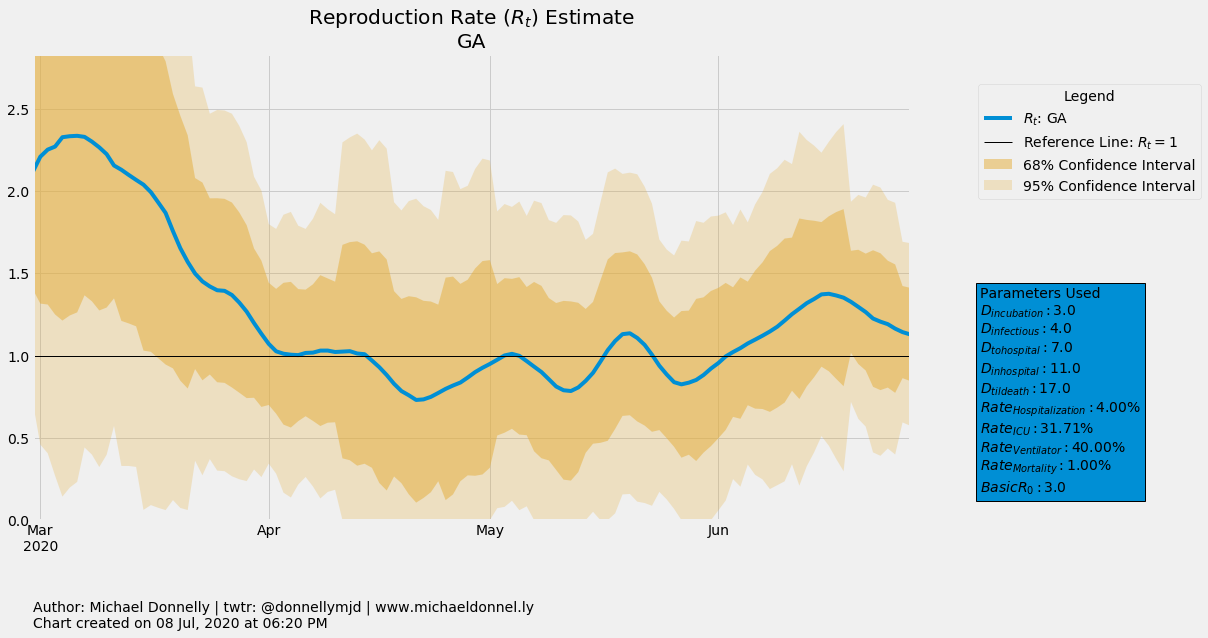

In [124]:
state = 'GA'
df_chart = df_wavg_rt_conf_allregs[[state]].unstack('metric')
ch_rt_confid(df_chart, 
             param_str_maker(model_dict), state)

In [125]:
# def add_plotly_footnote(fig):
#     fig.update_layout(
#                   annotations=[
#                       dict(x = 0, y = -0.075, showarrow = False,
#                            xref='paper', yref='paper', 
#                            xanchor='left', yanchor='auto', xshift=0, yshift=0,
#                            text='Author: Michael Donnelly | twtr: <a href="https://twitter.com/donnellymjd">@donnellymjd</a> | <a href="http://{0}">{0}</a>'.format(
#                            'www.michaeldonnel.ly')
#                           ),
#                       dict(x = 0, y = -0.09, showarrow = False,
#                            xref='paper', yref='paper', 
#                            xanchor='left', yanchor='auto', xshift=0, yshift=0,
#                            text='Chart created on {}'.format(pd.Timestamp.today().strftime("%d %b %Y"))
#                           )
#                   ]
#                  )
#     return fig

In [126]:
# import plotly.express as px

# df_chart = df_wavg_rt_conf_allregs.unstack('metric').apply(
#     lambda x: x.loc[x.last_valid_index()]).sort_values(ascending=False).unstack('metric')
# df_chart['e'] = df_chart.rt_u68 - df_chart.rt
# df_chart = df_chart.round(2)
# df_chart = df_chart.sort_values(by='rt').reset_index().rename(columns={'index':'state'})

# fig = px.scatter(df_chart,
#                  y="state", x="rt",
#                  error_x="e", color='rt',
#                  color_continuous_scale=px.colors.diverging.PiYG_r,
#                  color_continuous_midpoint=1.0,
#                  height=1000
#                 )

# fig.update_traces(mode='markers+text', 
#                   marker_line_width=1, 
#                   marker_size=13, 
#                   text=pd.Series(df_chart['state']).apply(
#                       lambda x: "<a href='http://www.michaeldonnel.ly/covid19/datacenter/{0}/' style='color: black'>{0}</a>".format(x)).to_list(),
#                   textfont=dict(size=8)
#                  )
# fig.update_layout(title='COVID-19: Current Estimated Reproduction Factor', 
#                   yaxis=dict(fixedrange=True),
#                   xaxis=dict(fixedrange=True)
#                  )
# fig = add_plotly_footnote(fig)
# fig.update_xaxes(title_text='Effective Reproduction Factor')
# fig.update_yaxes(title_text='State')

# fig.write_html('./output/state_fore/rt_summary.html')
# fig.write_html('../donnellymjd.github.io/_covid19/datacenter/plotly/rt_summary.html')


In [ ]:
fig = ch_rt_summary(df_wavg_rt_conf_allregs)
fig.write_html('./output/state_fore/rt_summary.html')
fig.write_html('../donnellymjd.github.io/_covid19/datacenter/plotly/rt_summary.html')


ID        VT        HI  OH        NH        AK        SD  \
dt         metric                                                             
2020-06-26 rt     NaN  1.130669  1.130312 NaN  1.805528  1.484404  0.955335   
2020-06-27 rt     NaN  1.279781  1.254557 NaN  1.666399  1.436537  1.056753   
2020-06-28 rt     NaN  1.422138  1.360522 NaN  1.556859  1.402125  1.159778   
2020-06-29 rt     NaN  1.579662  1.506792 NaN       NaN       NaN  1.269762   
2020-06-30 rt     NaN  1.658515  1.592855 NaN       NaN       NaN  1.341745   

                   FL  NV        LA  ...        MN        NM        MI  \
dt         metric                    ...                                 
2020-06-26 rt     NaN NaN  1.286672  ...  1.204935  1.113532  1.152779   
2020-06-27 rt     NaN NaN  1.283983  ...  1.193722  1.126190  1.160579   
2020-06-28 rt     NaN NaN  1.281142  ...       NaN  1.139775  1.164326   
2020-06-29 rt     NaN NaN       NaN  ...       NaN  1.168210  1.166541   
2020-06-30 rt     NaN NaN       NaN  ...       NaN  1.189392  1.169013   

                         NJ        VA        CA  AZ        GA        NE  \
dt         metric                                                         
2020-06-26 rt      1.033755  1.241062  1.157461 NaN  1.142315  0.862795   
2020-06-27 rt      1.082024  1.227051       NaN NaN  1.128746  0.939249   
2020-06-28 rt      1.121843  1.209898       NaN NaN       NaN  1.007408   
2020-06-29 rt      1.146001  1.185393       NaN NaN       NaN  1.070476   
2020-06-30 rt      1.162194  1.160390       NaN NaN       NaN  1.121181   

                         DC  
dt         metric            
2020-06-26 rt      0.956035  
2020-06-27 rt      0.990078  
2020-06-28 rt      1.011826  
2020-06-29 rt      1.076706  
2020-06-30 rt      1.104589  

[5 rows x 28 columns]

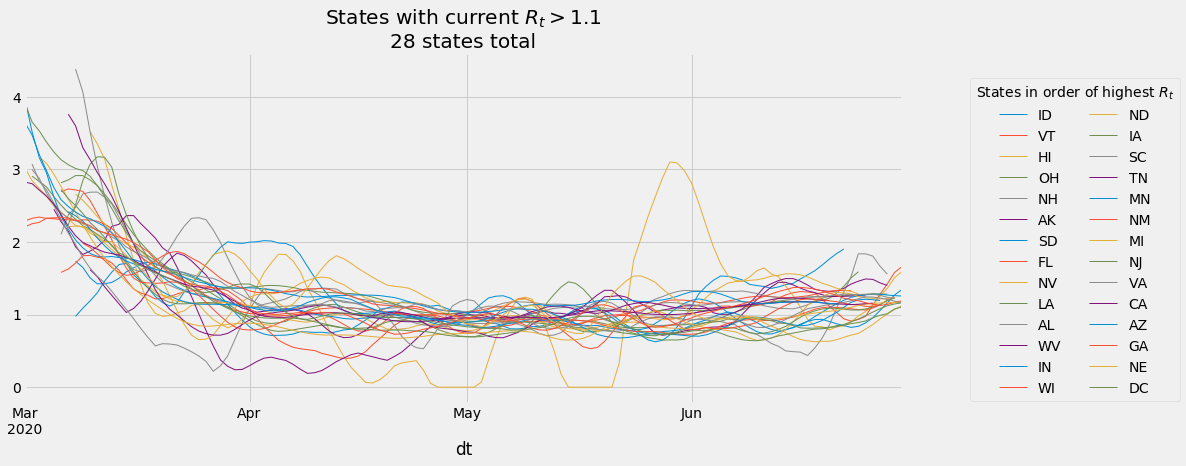

In [127]:
s_last_rt = df_wavg_rt_conf_allregs.loc[idx[:,'rt'],:].apply(
    lambda x: x.loc[x.last_valid_index()]).sort_values(ascending=False)

s_last_rt.name = 'rt_est_{}'.format(pd.Timestamp.today().strftime("%Y%m%d"))

s_last_rt.to_csv('./output/state_fore/rt_est_{}.csv'.format(pd.Timestamp.today().strftime("%Y%m%d")),
    encoding='utf-8')

s_states_above_1_1 = s_last_rt[s_last_rt.ge(1.1)].index

df_chart = df_wavg_rt_conf_allregs.loc[idx[:,'rt'], s_states_above_1_1]
df_chart.droplevel(1).loc['2020-03-01':].plot(figsize=[14,6], 
              title='States with current $R_t > 1.1$\n{0} states total'.format(s_states_above_1_1.shape[0]),
              linewidth=1.0)
plt.legend(loc='upper left', bbox_to_anchor=(1.07, 0.95), ncol=2, title='States in order of highest $R_t$')

display(df_chart.tail())

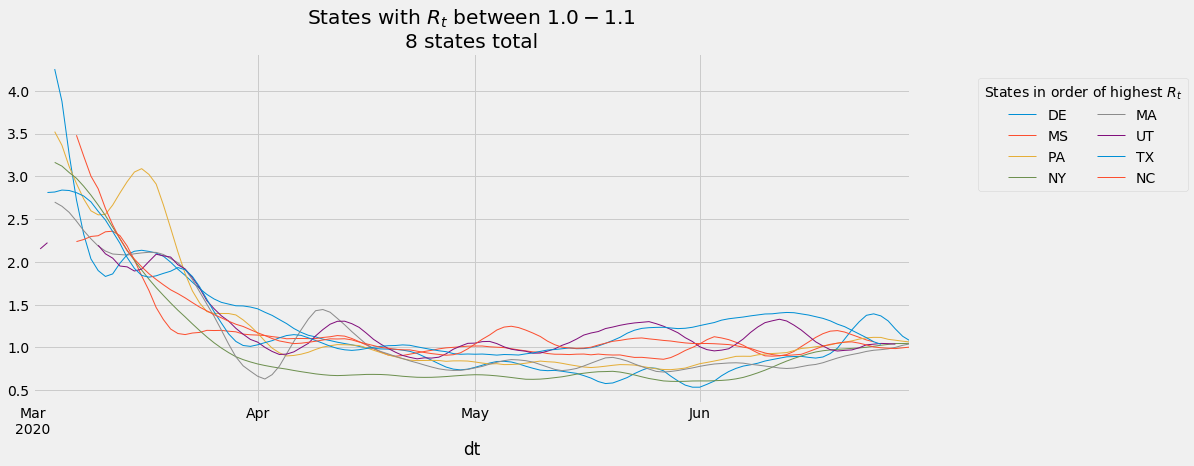

In [128]:
s_states_for_chart = s_last_rt[s_last_rt.ge(1.0) & s_last_rt.lt(1.1)].index

df_chart = df_wavg_rt_conf_allregs.loc[idx[:,'rt'], s_states_for_chart]
df_chart.droplevel(1).loc['2020-03-01':].plot(figsize=[14,6], 
              title='States with $R_t$ between $1.0-1.1$\n{0} states total'.format(s_states_for_chart.shape[0]),
              linewidth=1.0)
plt.legend(loc='upper left', bbox_to_anchor=(1.07, 0.95), ncol=2, title='States in order of highest $R_t$')


Best starting date:  2020-02-27 00:00:00


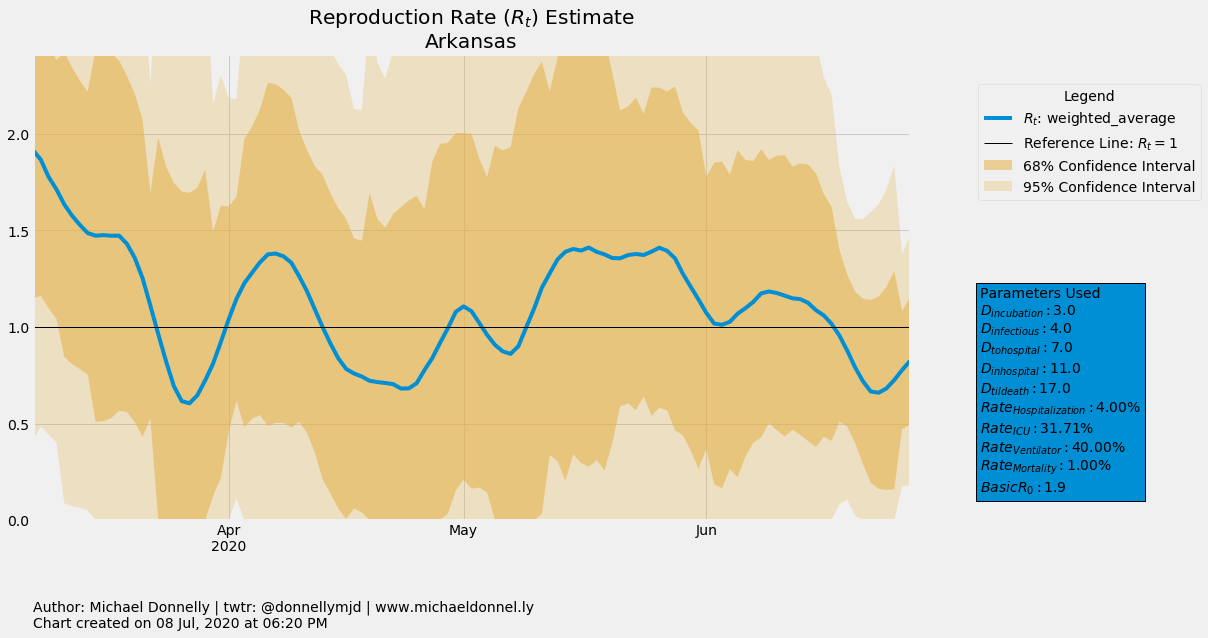

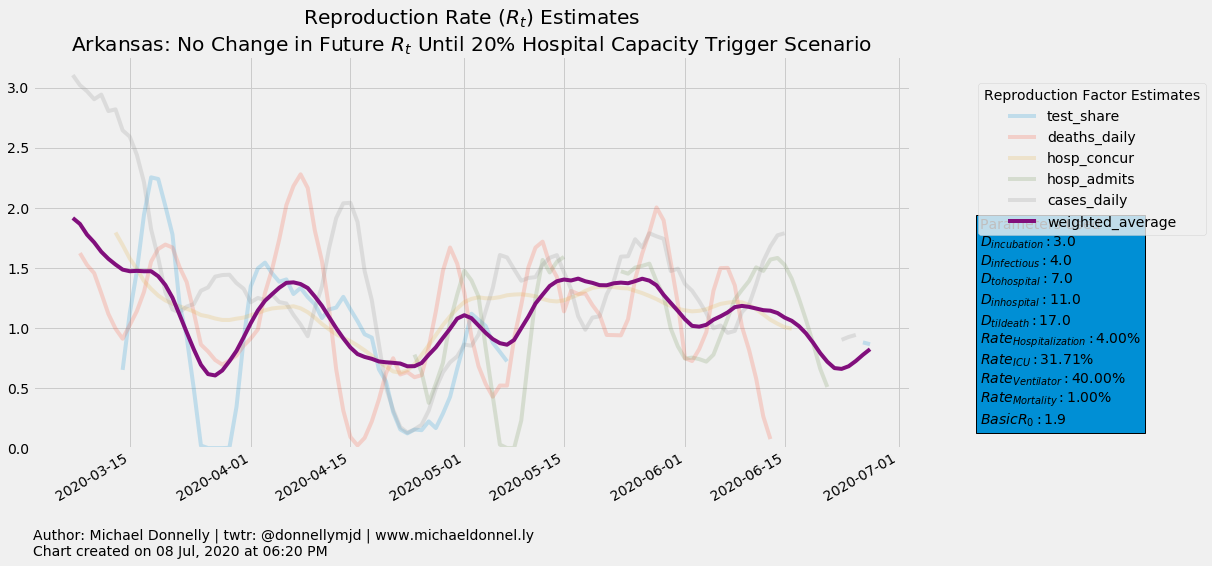

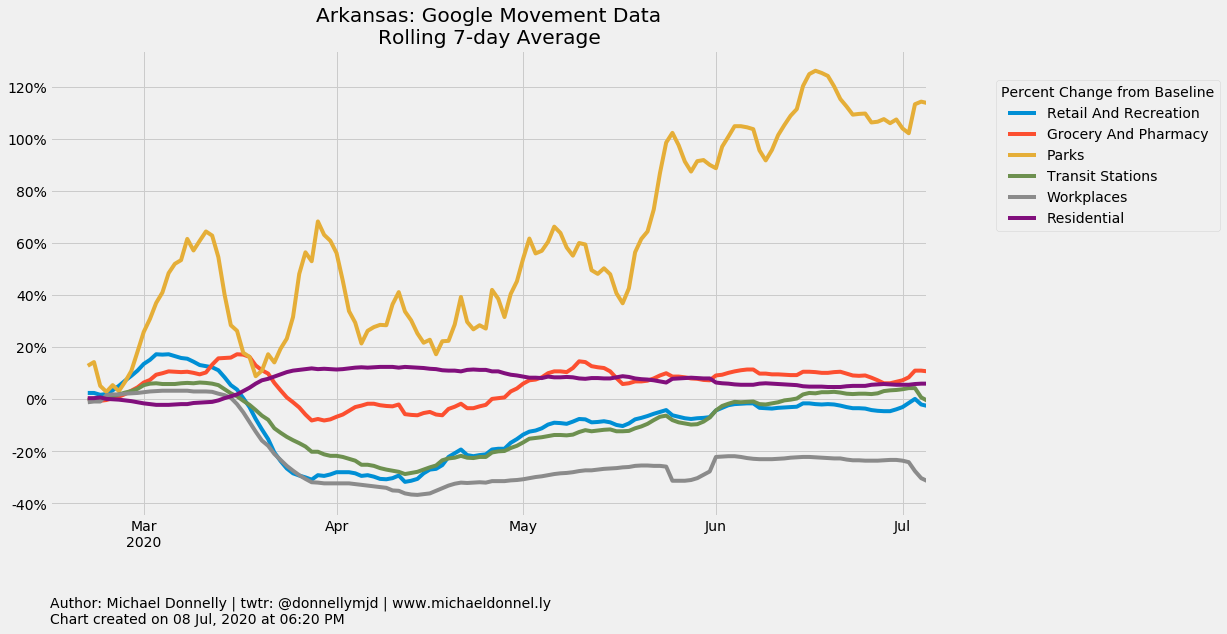

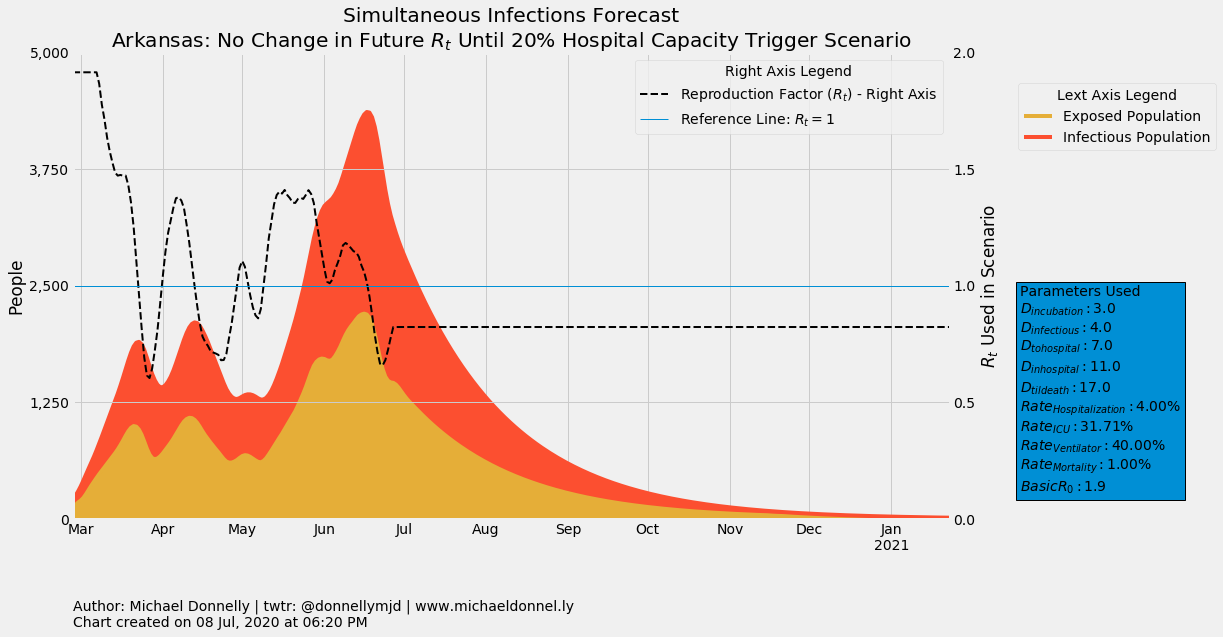

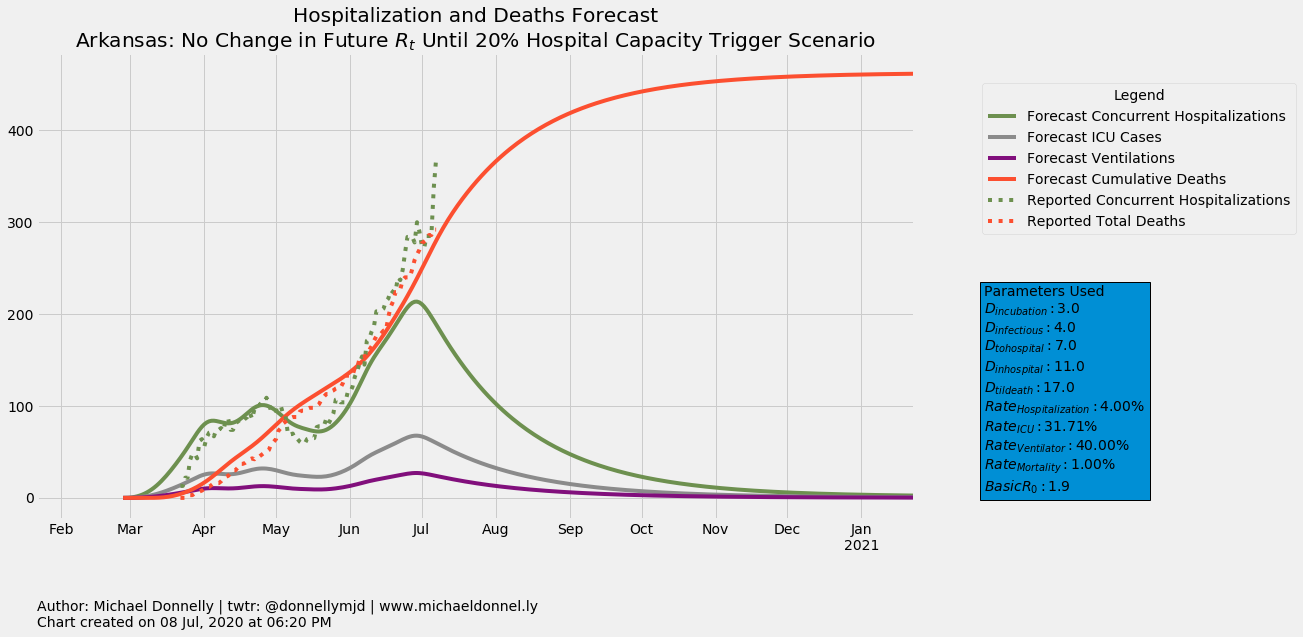

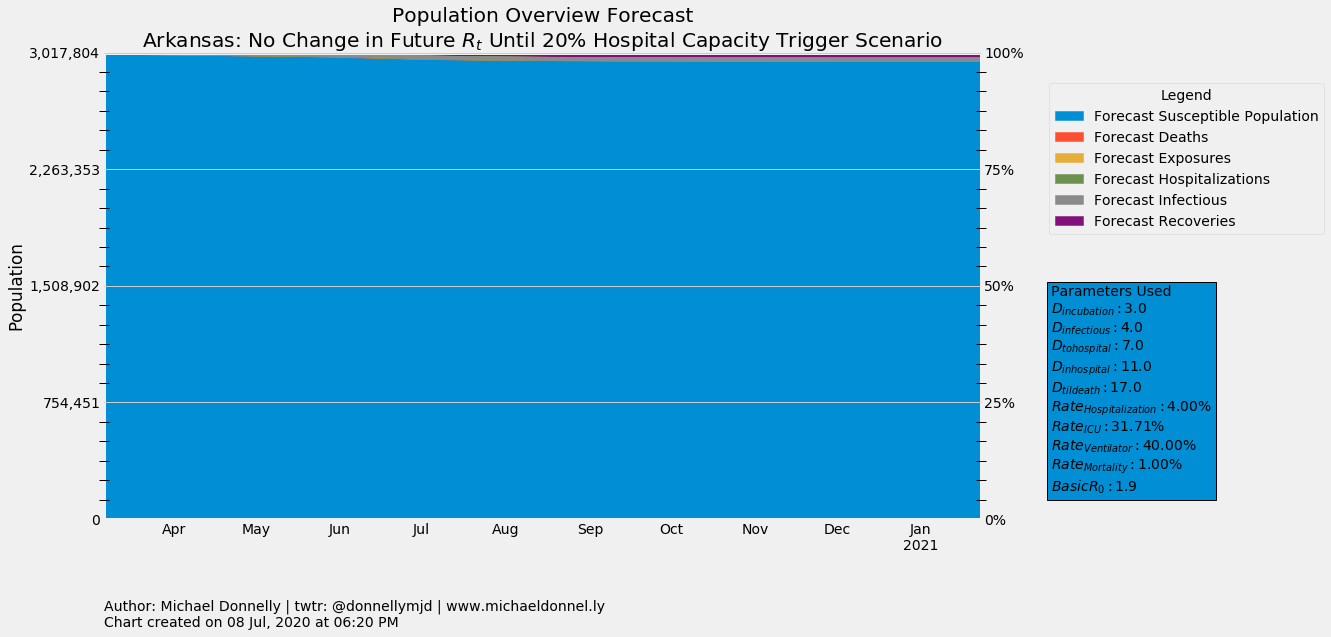

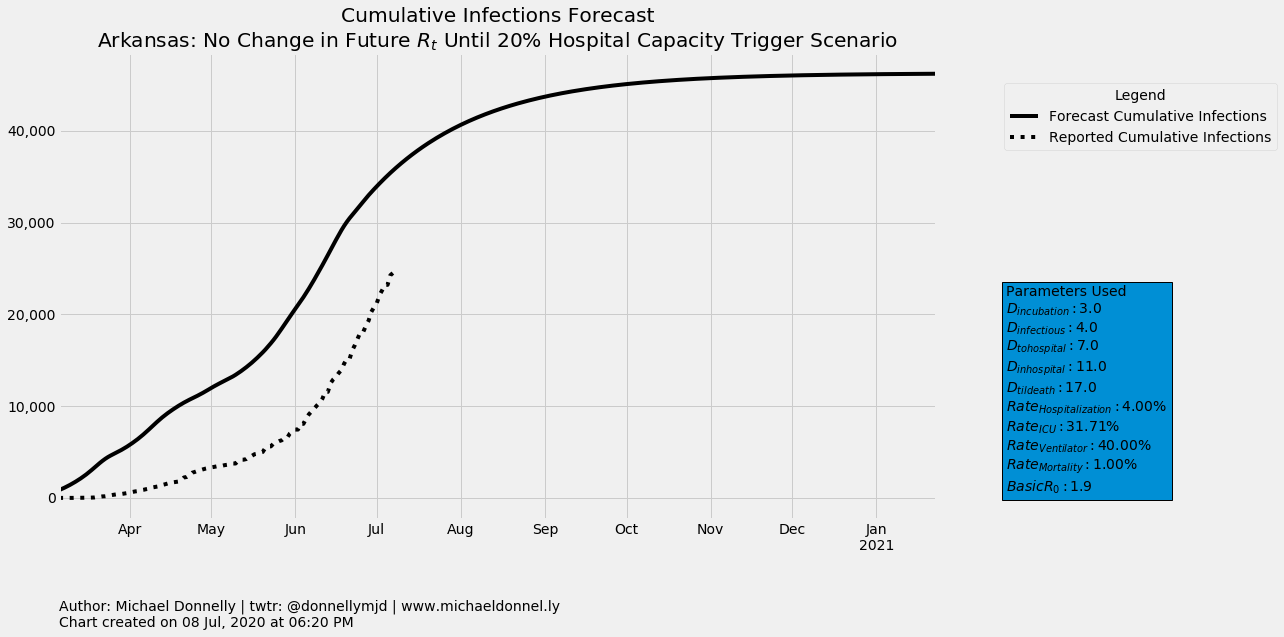

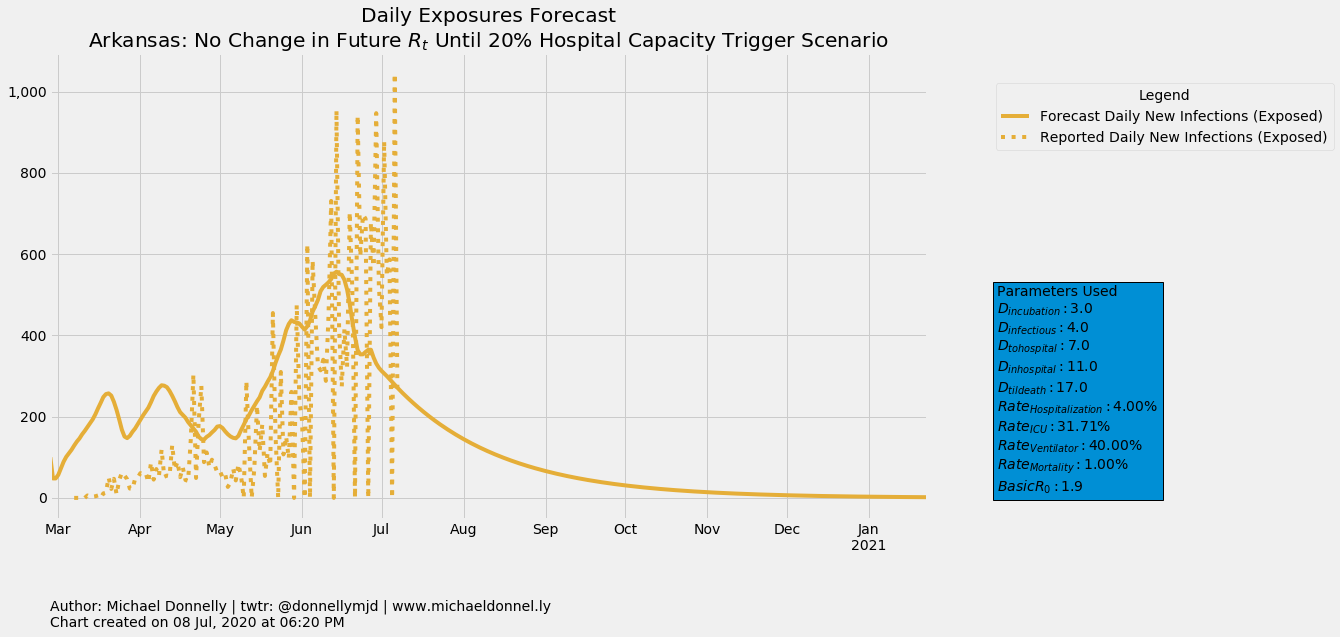

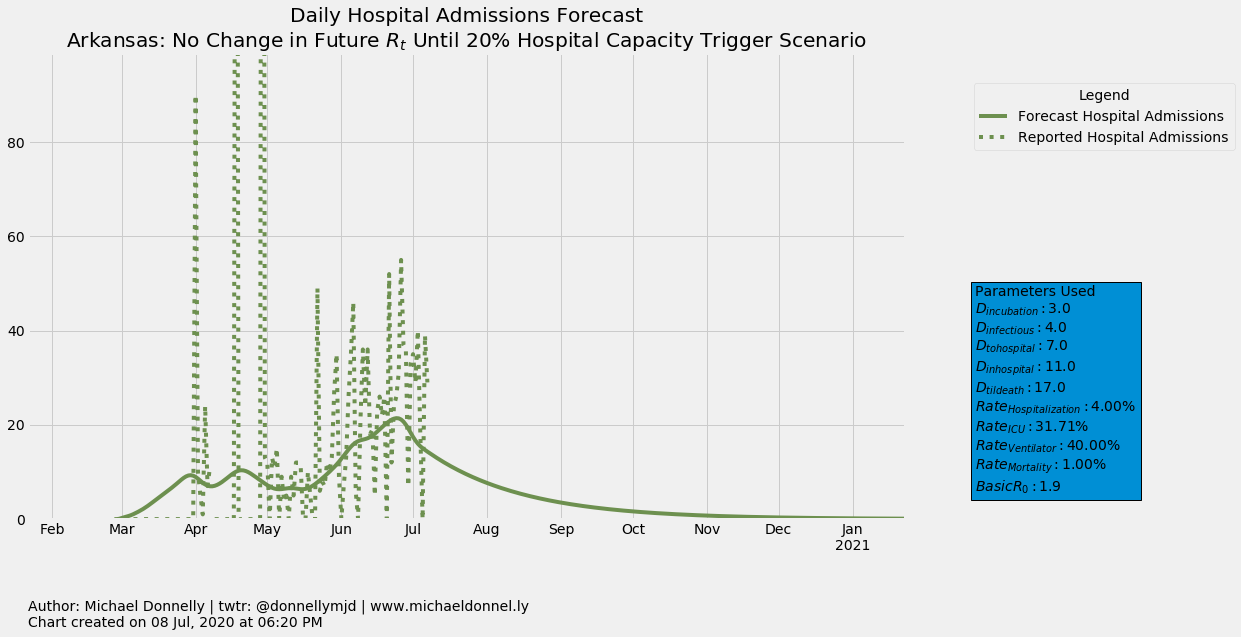

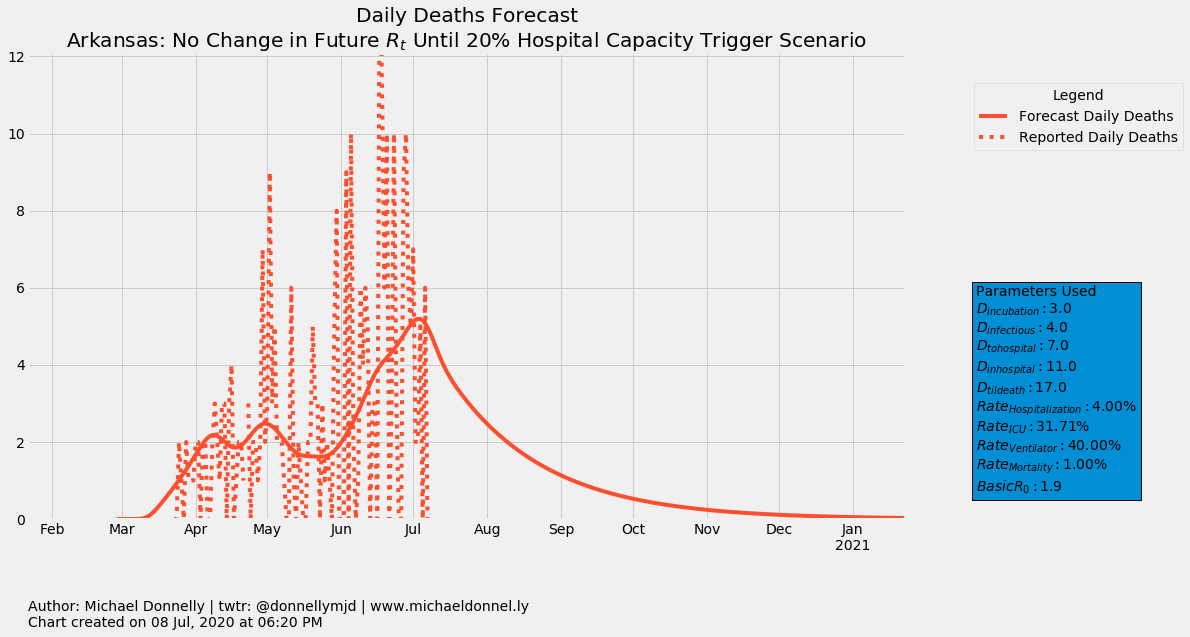

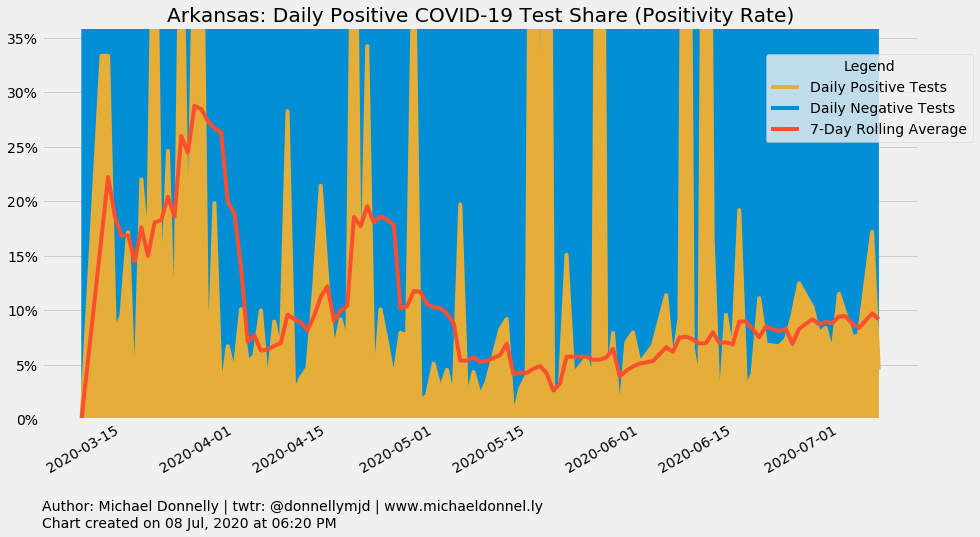

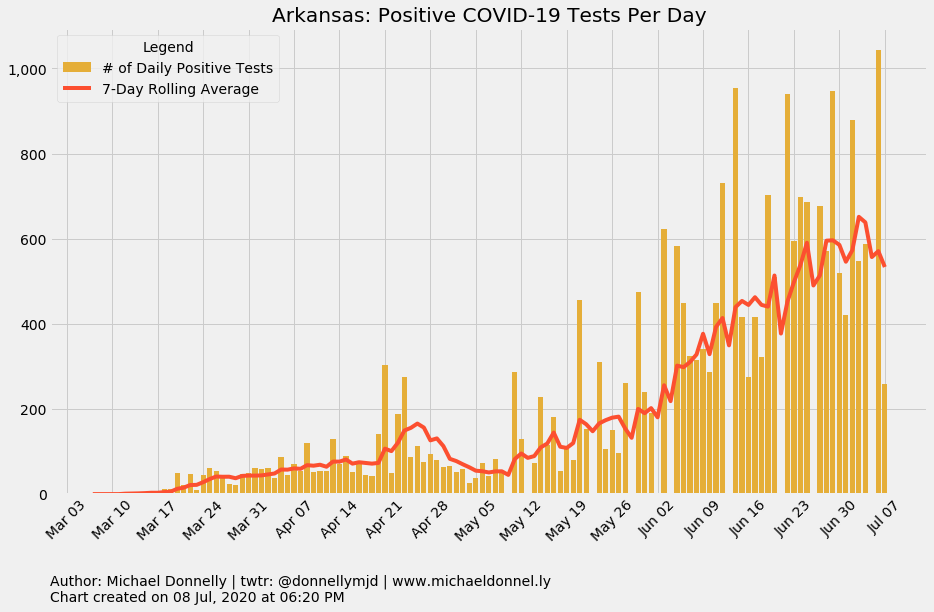

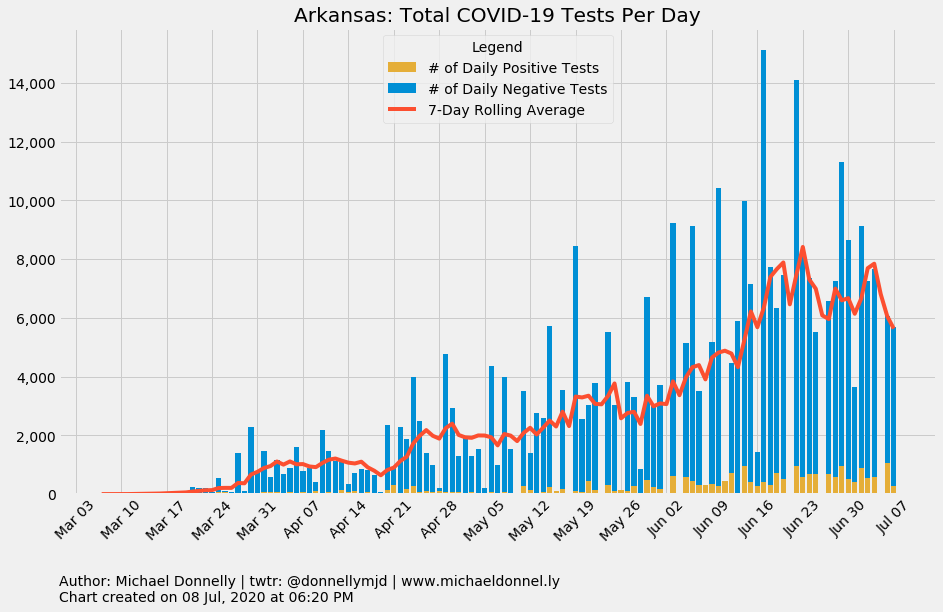

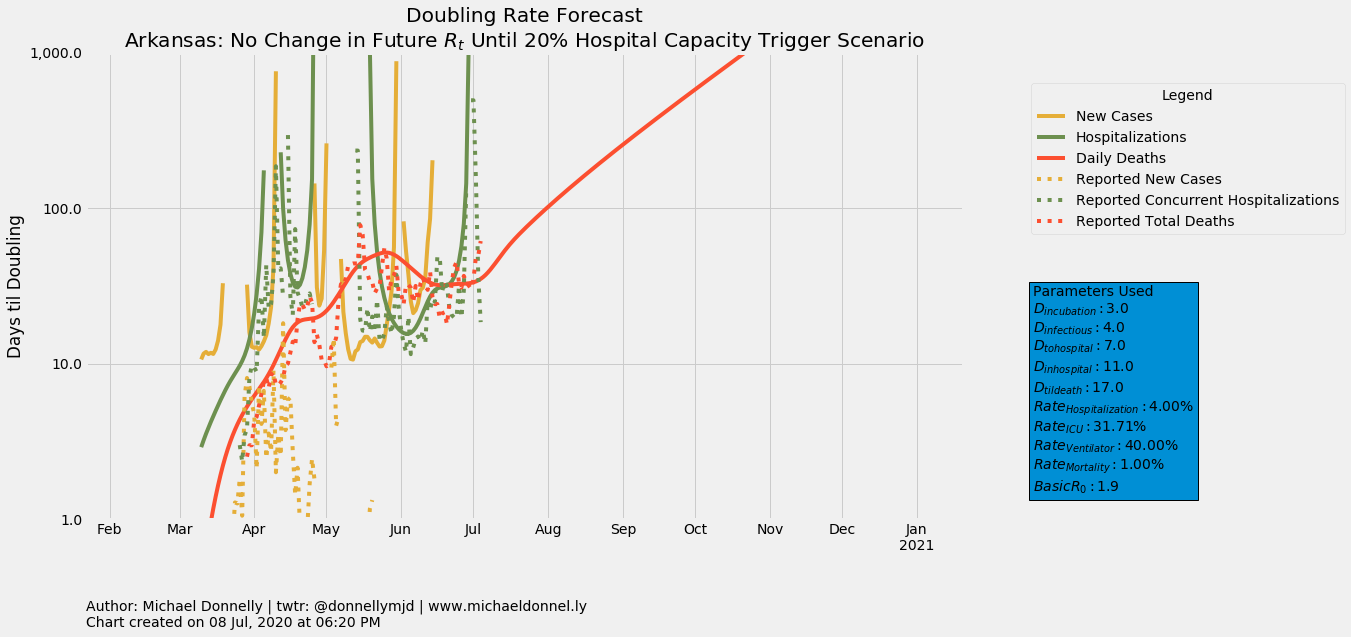

Peak Hospitalization Date:  29 Jun, 2020
Peak Hospitalization #: 214
Peak ICU #: 68
Peak Ventilator #: 27


In [129]:
state = 'AR'
cover_file = './output/state_fore/coverpage.pdf'
chart_file = './output/state_fore/charts.pdf'

model_dict = make_model_dict_state(state, abbrev_us_state, df_census, df_st_testing_fmt, covid_params, 200,
                                   df_mvmt=df_goog_mob_state
#                                    , df_interventions=df_interventions)
                                  )


first_guess = pd.Timestamp('2020-02-20')
df_agg, df_all_cohorts, model_dict = model_find_start(first_guess, model_dict)
# df_agg, df_all_cohorts, model_dict = seir_model_cohort(pd.Timestamp('2020-02-18'), 
#                                                        model_dict, 
#                                                        max(min(model_dict['df_hist']['cases_tot'].max() / 100, 100), 10),
#                                                        max(min(model_dict['df_hist']['cases_tot'].max() / 100, 100), 10))

# fig = ch_statemap2(df_counties.query('dt == dt.max() and state == "{}"'.format(state)), 
#                    abbrev_us_state[state], 
#                    df_counties.query('dt == dt.max()').cases_per100k.quantile(.9),
#                    counties_geo
#                   )
# pio.orca.shutdown_server()
# fig.write_image(cover_file, scale=2)
# fig.show()
# pdf_obj = PdfPages(chart_file)

run_all_charts(model_dict, df_agg, r'No Change in Future $R_{t}$ Until 20% Hospital Capacity Trigger', 
               False, True)

# pdf_obj.close()

# pdf_out = './output/state_fore/coronita_forecast_{}_{}.pdf'.format(
#     state, pd.Timestamp.today().strftime("%Y%m%d"))
# gs_cmd = 'gs -dBATCH -dNOPAUSE -q -sDEVICE=pdfwrite -dPDFSETTINGS=/prepress -sOutputFile='
# cmd_str = '{0}{1} {2} {3}'.format(
#     gs_cmd, pdf_out, cover_file, chart_file)
# os.system(cmd_str)
    

In [131]:
cover_file = './output/state_fore/coverpage.pdf'
chart_file = './output/state_fore/charts.pdf'

df_fore_allstates = pd.DataFrame()

try:
    df_prevfore_allstates = pd.read_pickle('./output/df_fore_allstates_{}.pkl'.format(
        (pd.Timestamp.today() - pd.Timedelta(days=1)).strftime("%Y%m%d")))
except:
    if 'df_fore_allstates' in globals().keys():
        if df_fore_allstates.shape[0] > 0:
            df_prevfore_allstates = df_fore_allstates.copy()

allstate_model_dicts = {}
l_pdfs_out = []

for state in df_census.state.unique():
    print(state)
    
    model_dict = make_model_dict_state(state, abbrev_us_state, df_census, df_st_testing_fmt, covid_params, 150,
                                       df_mvmt=df_goog_mob_state
#                                        , df_interventions=df_interventions
                                      )
    
    fig = ch_statemap2(df_counties.query('dt == dt.max() and state == "{}"'.format(state)), 
                       abbrev_us_state[state], 
                       df_counties.query('dt == dt.max()').cases_per100k.quantile(.9),
                       counties_geo
                      )
    fig = add_plotly_footnote(fig)
    pio.orca.shutdown_server()
    fig.write_html('../donnellymjd.github.io/_covid19/datacenter/plotly/{}_casepercap_cnty_map.html'.format(
        model_dict['region_code']))
    try:
        pio.orca.shutdown_server()
        fig.write_image(cover_file, scale=2)
    except:
        pio.orca.shutdown_server()

    pdf_obj = PdfPages(chart_file)

    try:
        first_guess = df_prevfore_allstates[state].first_valid_index()[0]
    except:
        first_guess = pd.Timestamp('2020-02-17')

    df_agg, df_all_cohorts, model_dict = model_find_start(first_guess, model_dict)

    allstate_model_dicts[state] = model_dict
    df_fore_allstates = pd.concat([df_fore_allstates,pd.DataFrame(df_agg.stack(), columns=[state])], axis=1)

    run_all_charts(allstate_model_dicts[state], 
                   df_fore_allstates[state].unstack('metric'), 
                   r'No Change in Future $R_{t}$ Until 20% Hospital Capacity Trigger', pdf_obj, False, 
                   pub2web=True)
    pdf_obj.close()

    pdf_out = './output/state_fore/coronita_forecast_{}_{}.pdf'.format(
        state, pd.Timestamp.today().strftime("%Y%m%d"))
    gs_cmd = 'gs -dBATCH -dNOPAUSE -q -sDEVICE=pdfwrite -dPDFSETTINGS=/prepress -sOutputFile='
    cmd_str = '{0}{1} {2} {3}'.format(
        gs_cmd, pdf_out, cover_file, chart_file)
    os.system(cmd_str)
    l_pdfs_out.append(pdf_out)

pdf_out = './output/state_fore/coronita_forecast_{}_{}.pdf'.format(
    'us', pd.Timestamp.today().strftime("%Y%m%d"))
gs_cmd = 'gs -dBATCH -dNOPAUSE -q -sDEVICE=pdfwrite -dPDFSETTINGS=/prepress -sOutputFile='
cmd_str = '{0}{1} {2}'.format(
    gs_cmd, pdf_out, ' '.join(sorted(l_pdfs_out)))
os.system(cmd_str)

AL
Best starting date:  2020-03-06 00:00:00
Peak Hospitalization Date:  22 Aug, 2020
Peak Hospitalization #: 3474
Peak ICU #: 1102
Peak Ventilator #: 441
AK
Best starting date:  2020-03-01 00:00:00
Peak Hospitalization Date:  06 Nov, 2020
Peak Hospitalization #: 671
Peak ICU #: 213
Peak Ventilator #: 85
AZ
Best starting date:  2020-02-26 00:00:00
Peak Hospitalization Date:  29 Aug, 2020
Peak Hospitalization #: 4397
Peak ICU #: 1394
Peak Ventilator #: 558
AR
Best starting date:  2020-02-27 00:00:00
Peak Hospitalization Date:  29 Jun, 2020
Peak Hospitalization #: 214
Peak ICU #: 68
Peak Ventilator #: 27
CA
Best starting date:  2020-02-12 00:00:00
Peak Hospitalization Date:  12 Oct, 2020
Peak Hospitalization #: 23672
Peak ICU #: 7506
Peak Ventilator #: 3002
CO
Best starting date:  2020-02-21 00:00:00
Peak Hospitalization Date:  26 Apr, 2020
Peak Hospitalization #: 963
Peak ICU #: 305
Peak Ventilator #: 122
CT
Best starting date:  2020-02-08 00:00:00
Peak Hospitalization Date:  19 Apr, 202

0

In [132]:
df_fore_allstates.unstack('metric').to_csv(
    './output/df_fore_allstates_{}.csv'.format(pd.Timestamp.today().strftime("%Y%m%d")),
    encoding='utf-8')
df_fore_allstates.to_pickle('./output/df_fore_allstates_{}.pkl'.format(pd.Timestamp.today().strftime("%Y%m%d")))

import pickle

asmd_filename = './output/allstate_model_dicts_{}.pkl'.format(pd.Timestamp.today().strftime("%Y%m%d"))

with open(asmd_filename, 'wb') as handle:
    pickle.dump(allstate_model_dicts, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('filename.pickle', 'rb') as handle:
#     b = pickle.load(handle)


## US Charts

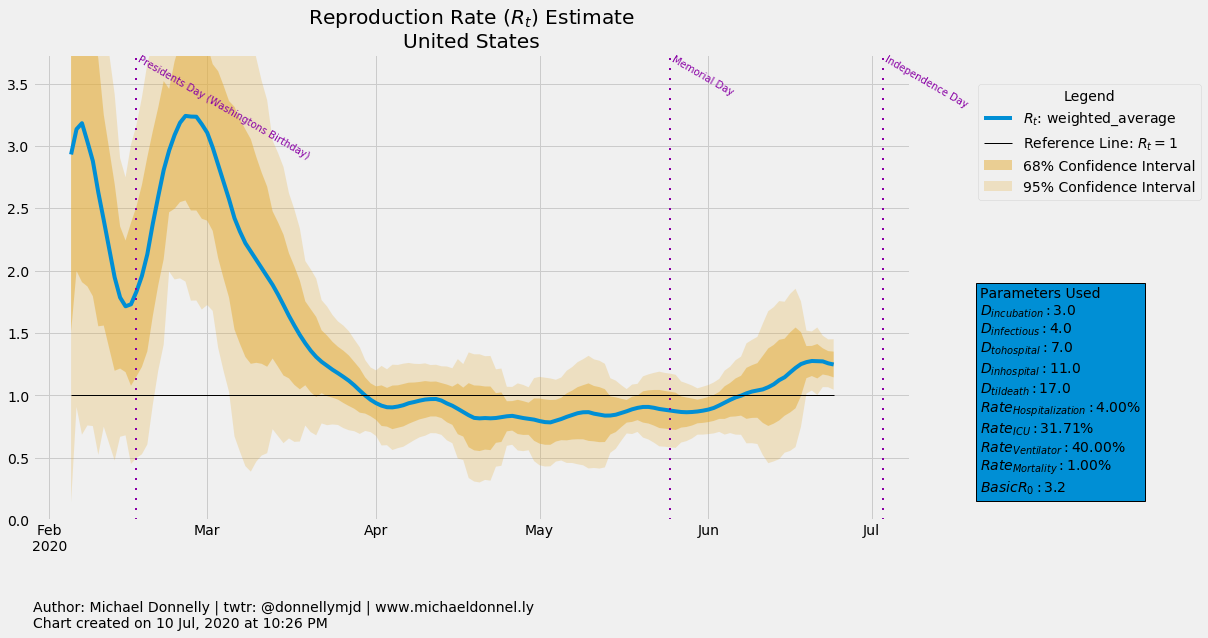

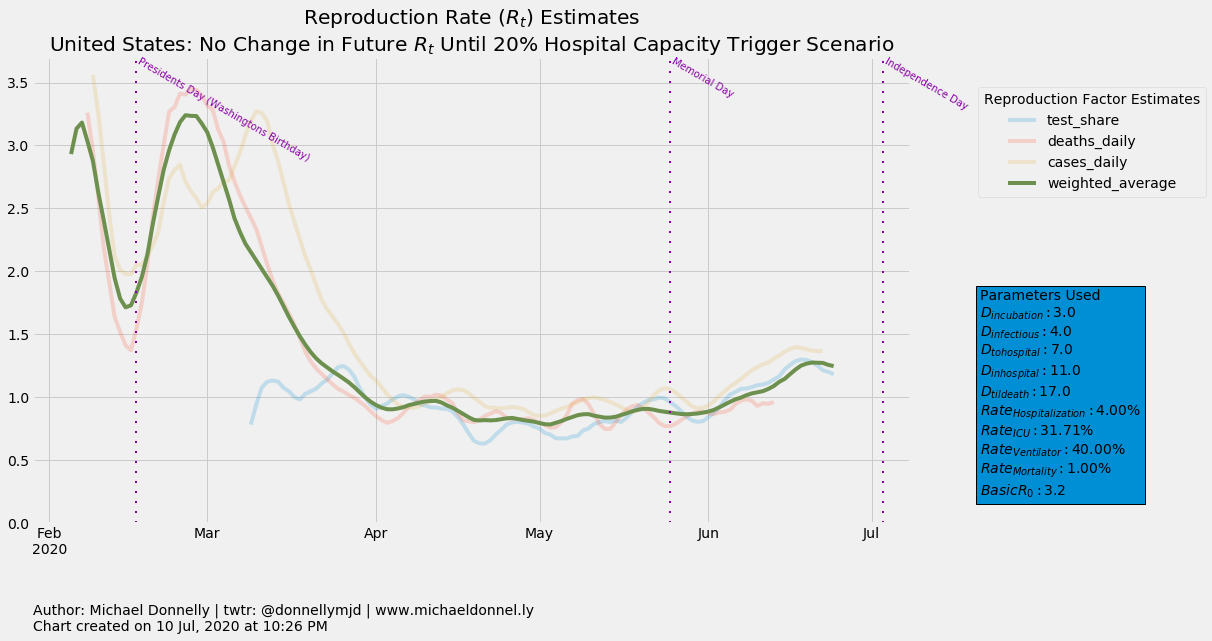

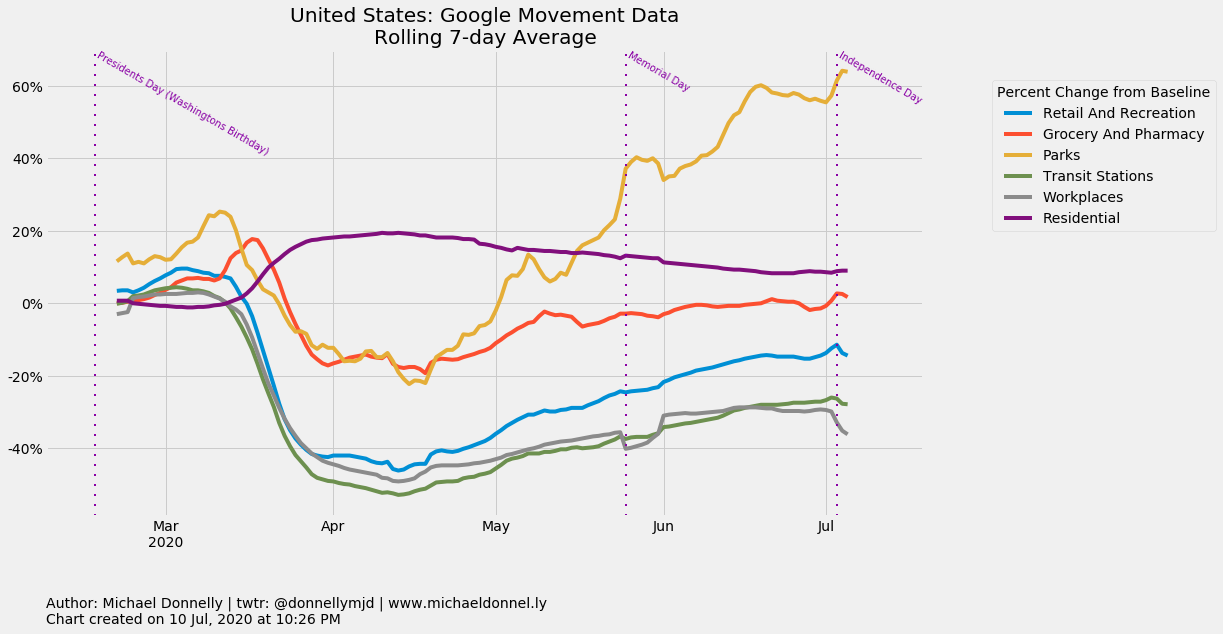

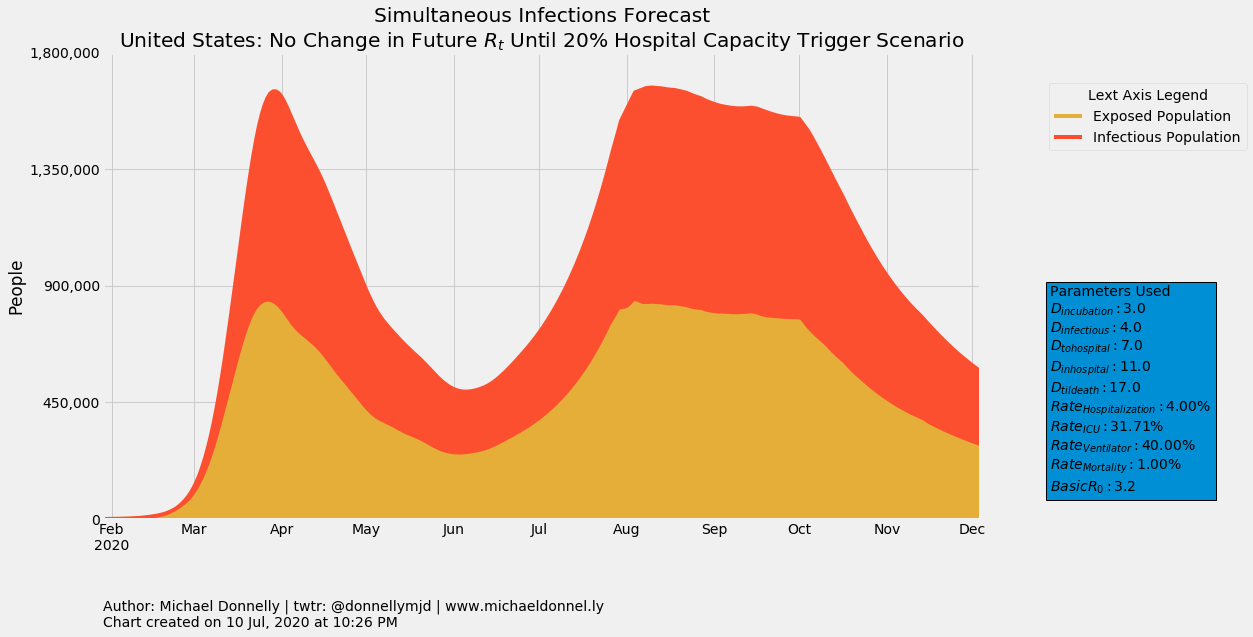

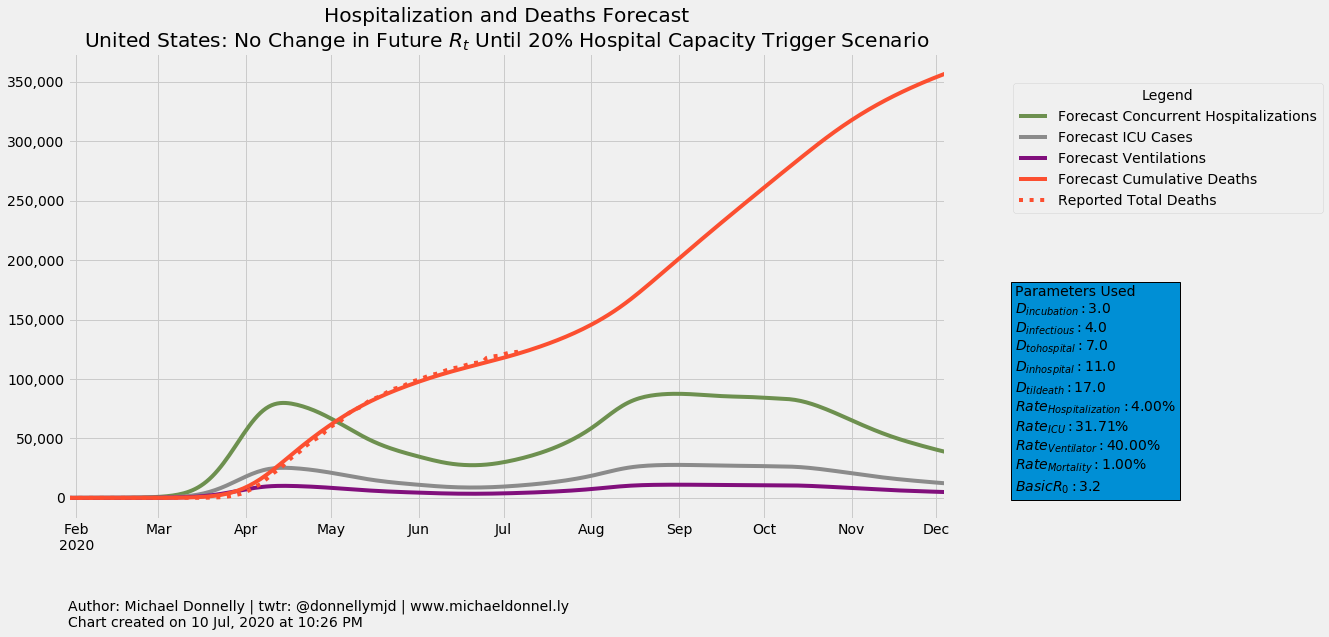

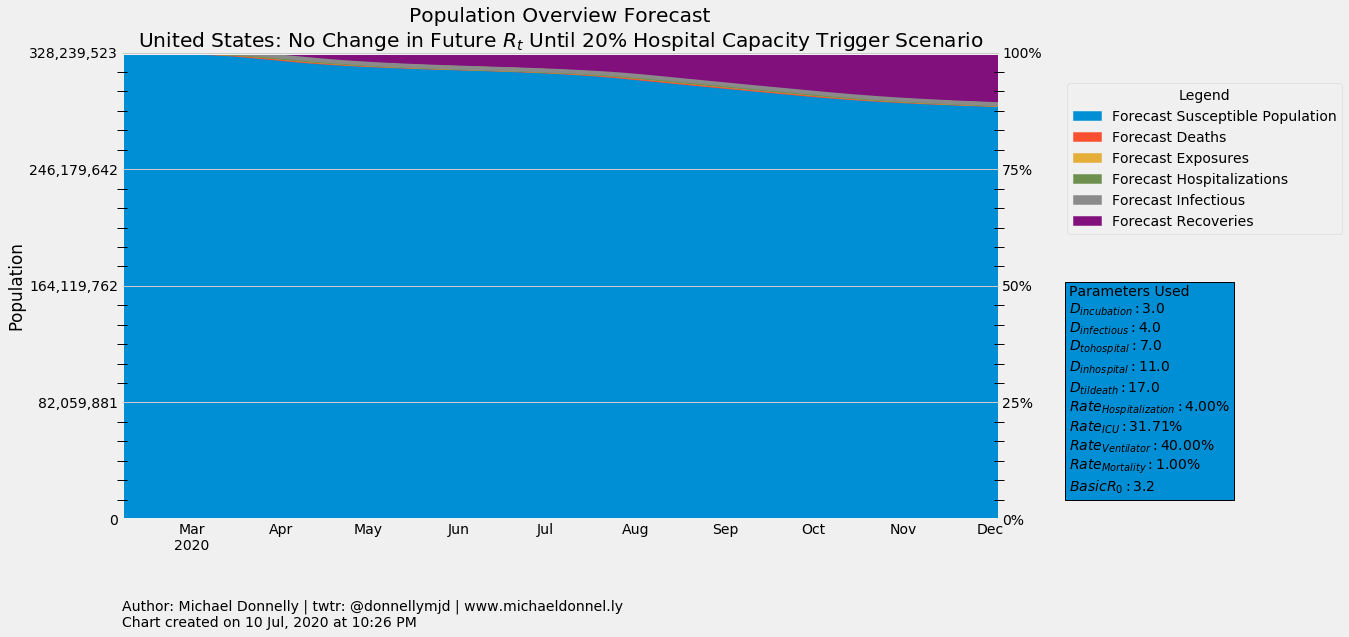

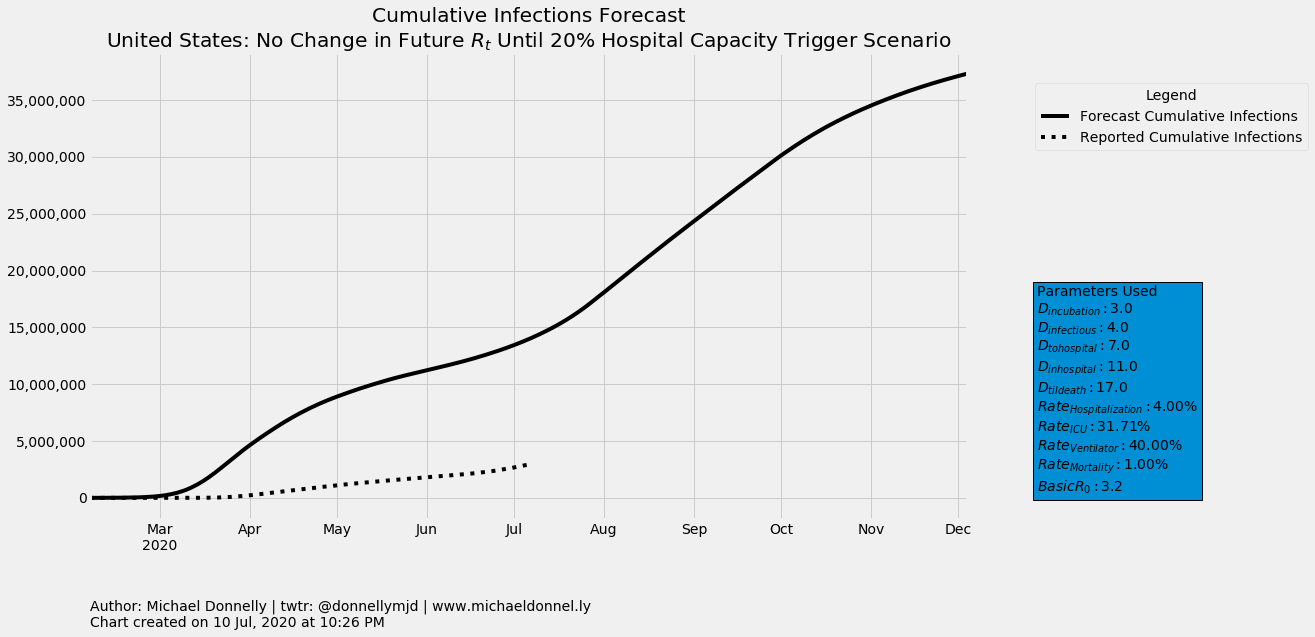

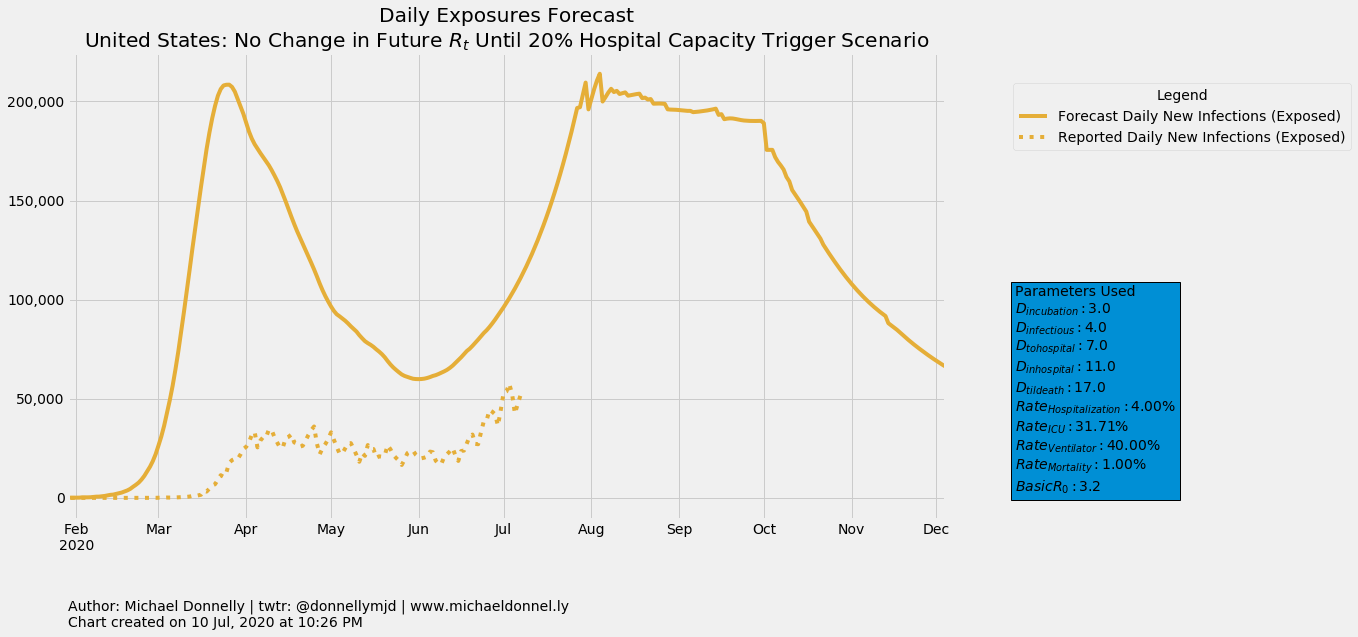

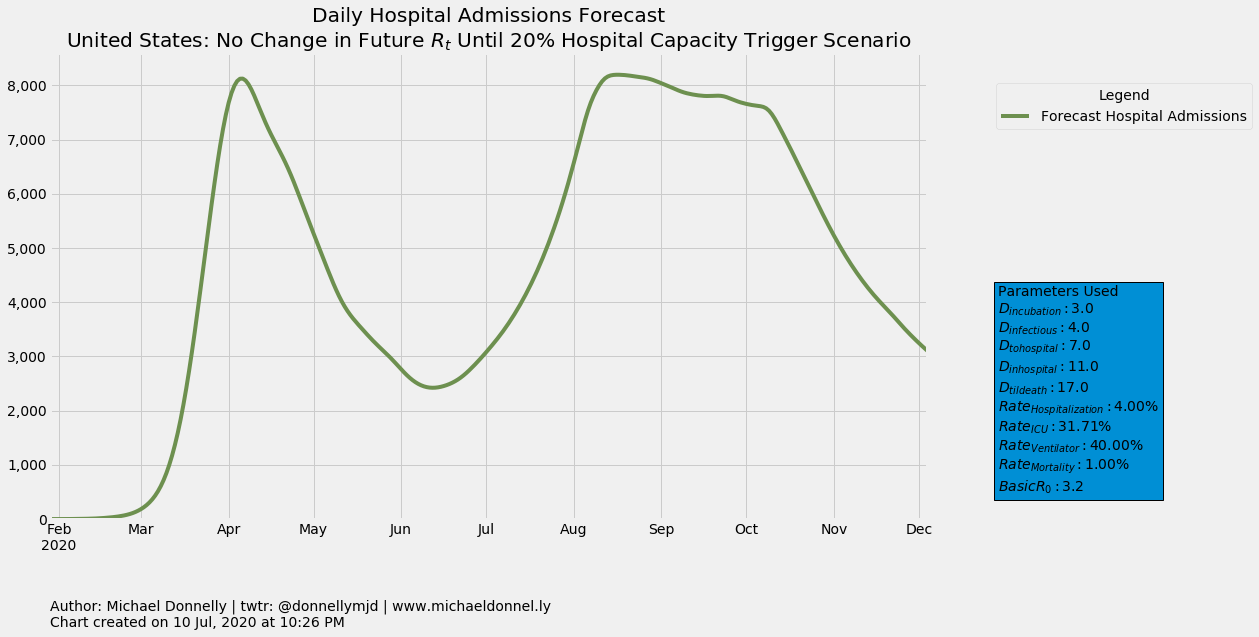

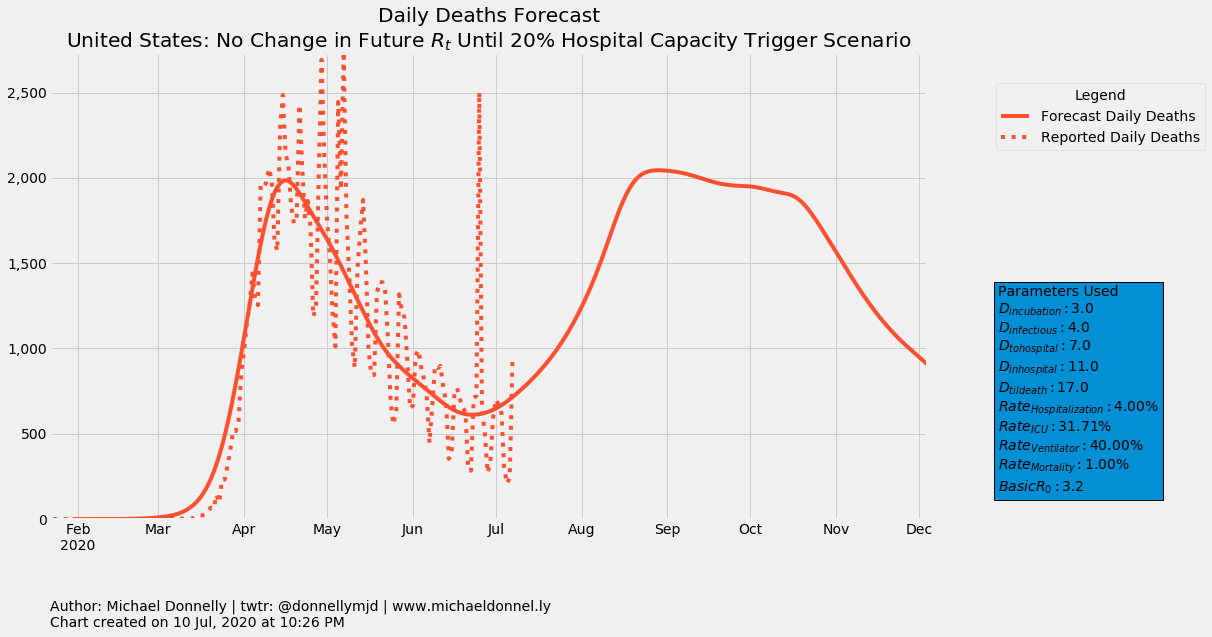

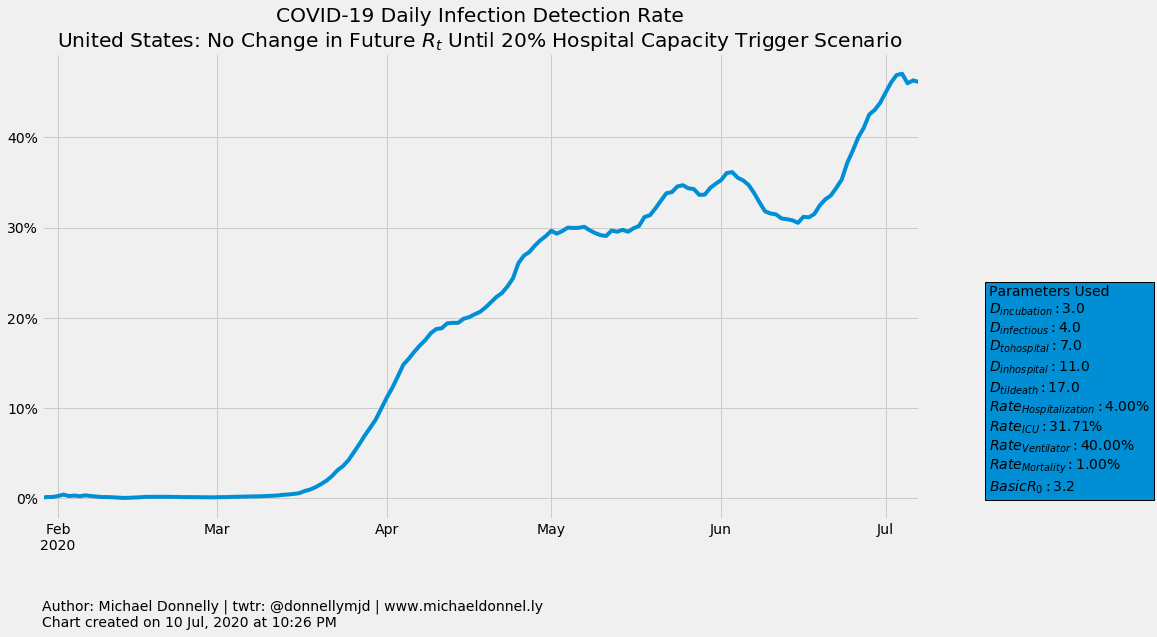

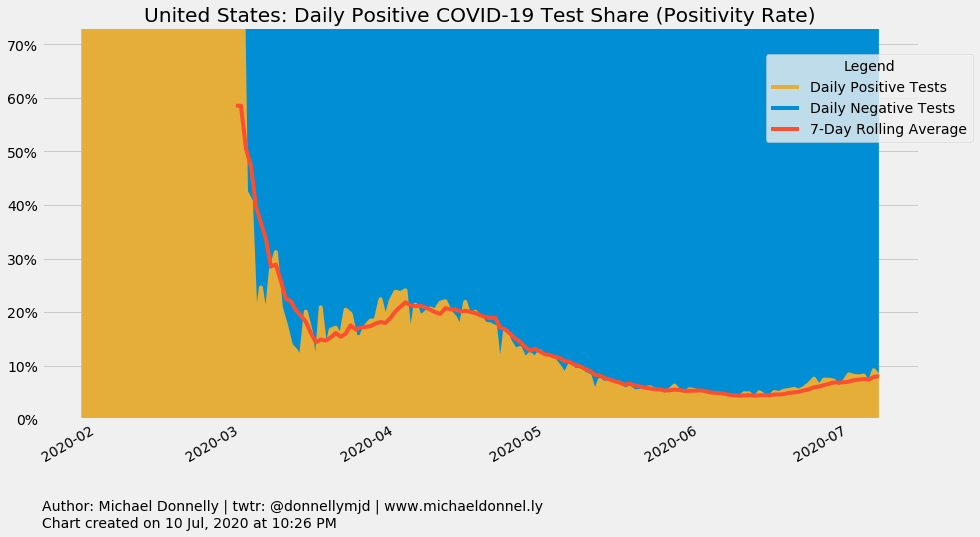

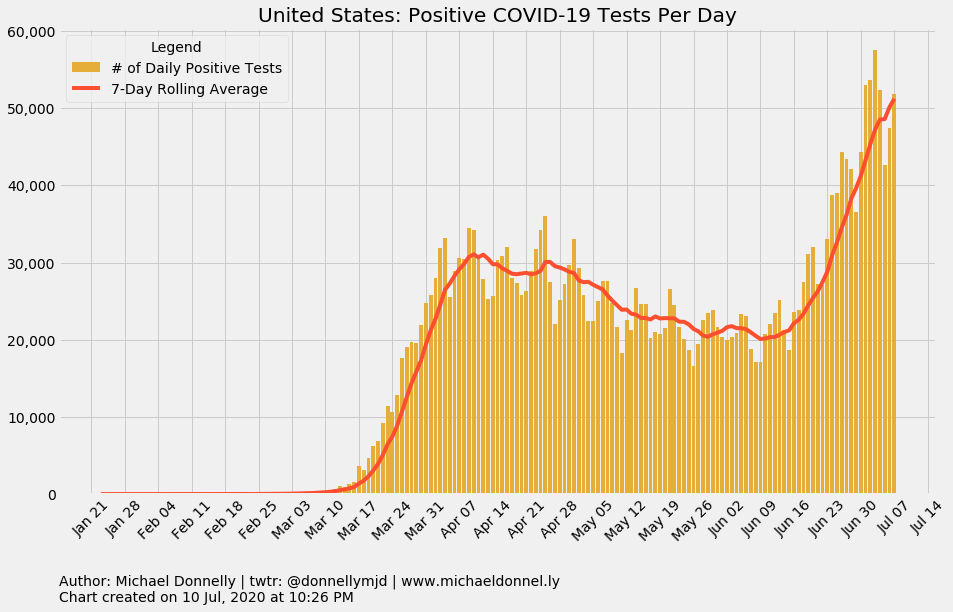

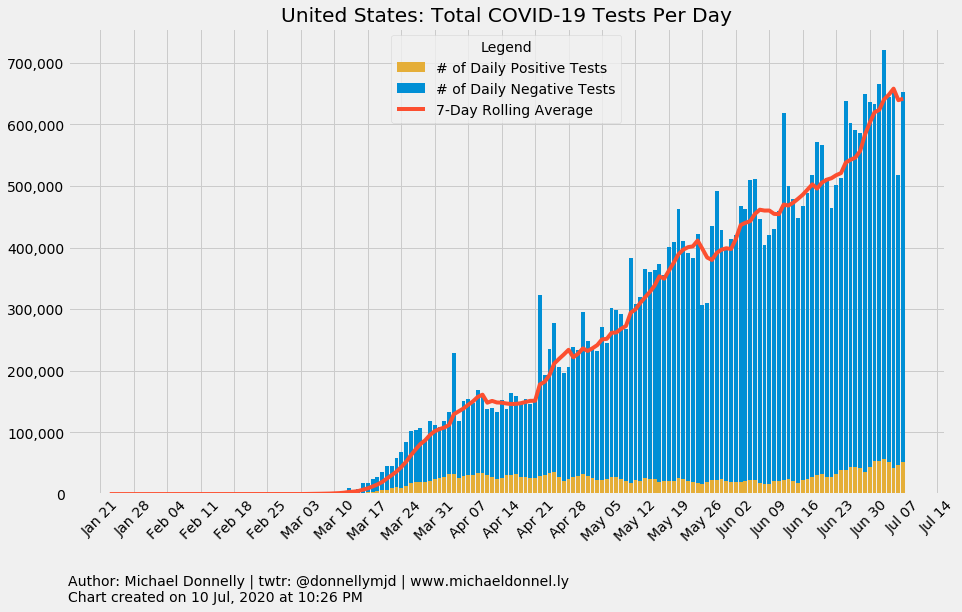

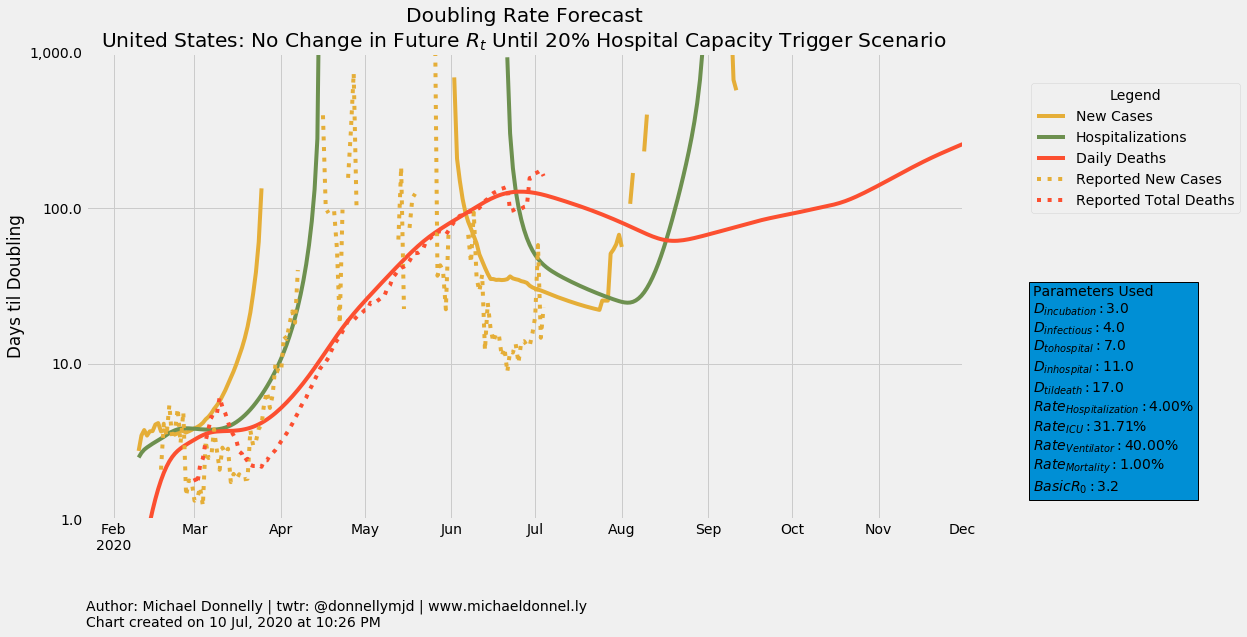

Peak Hospitalization Date:  31 Aug, 2020
Peak Hospitalization #: 87573
Peak ICU #: 27767
Peak Ventilator #: 11107


0

In [241]:
cover_file = './output/state_fore/coverpage.pdf'
chart_file = './output/state_fore/charts.pdf'
model_dict = make_model_dict_us(df_census, df_st_testing_fmt, covid_params, d_to_forecast = 75,
                               df_mvmt=df_goog_mob_us, df_interventions=df_interventions)

fig = ch_statemap2(df_counties.query('dt == dt.max()'), 
                   'USA', 
                   df_counties.query('dt == dt.max()').cases_per100k.quantile(.9),
                   counties_geo,
                   fitbounds=False)
# fig.show()

pio.orca.shutdown_server()
fig.write_html('../donnellymjd.github.io/_covid19/datacenter/plotly/{}_casepercap_cnty_map.html'.format(
    model_dict['region_code']))
fig.write_image(cover_file, scale=2)

pdf_obj = PdfPages(chart_file)

df_fore_us = df_fore_allstates.sum(axis=1, skipna=True).unstack('metric').dropna(how='all')
tot_pop = df_fore_us[['susceptible', 'deaths', 'exposed', 'hospitalized', 'infectious', 'recovered']].sum(axis=1)
max_tot_pop = tot_pop.max()
df_fore_us.loc[tot_pop<max_tot_pop, 'susceptible'] = df_fore_us['susceptible'] + (max_tot_pop - tot_pop)

run_all_charts(model_dict, 
               df_fore_us, 
               scenario_name=r'No Change in Future $R_{t}$ Until 20% Hospital Capacity Trigger', 
               pdf_out=pdf_obj, 
               show_charts=True,
               pub2web=True
              )
pdf_obj.close()

pdf_out = './output/state_fore/coronita_forecast_{}_{}.pdf'.format(
    'us', pd.Timestamp.today().strftime("%Y%m%d"))
gs_cmd = 'gs -dBATCH -dNOPAUSE -q -sDEVICE=pdfwrite -dPDFSETTINGS=/prepress -sOutputFile='
cmd_str = '{0}{1} {2}'.format(
    gs_cmd, pdf_out, ' '.join([cover_file, chart_file] + sorted(l_pdfs_out)))
os.system(cmd_str)

In [220]:
cmd_str = '{0}{1} {2}'.format(
    gs_cmd, pdf_out, ' '.join([cover_file, chart_file] + sorted(l_pdfs_out)))
os.system(cmd_str)

0

In [245]:
# infectious_contact_prob = df_fore_allstates.loc[
#     pd.Timestamp.today().date()].loc[['exposed','infectious']].sum().div(
#     df_census[df_census.SUMLEV==40].set_index('state')['pop2019']).sort_values()

# df_chart = (1-(1-infectious_contact_prob)**10).reset_index()
# df_chart.columns = ['state','Exposure Probability (%)']
# df_chart['Exposure Probability (%)'] = df_chart['Exposure Probability (%)'].mul(100).round(1)

# import plotly.express as px


# chart_title = 'US: Current Model-Estimated COVID-19 Exposure Probability Per 10 Contacts'

# fig = px.choropleth(df_chart[['state','Exposure Probability (%)']],
#                     locations=df_chart['state'], 
#                     locationmode="USA-states",
#                     color='Exposure Probability (%)',
#                     color_continuous_scale="BuPu",
#                     title=chart_title,
#                     projection='albers usa'
#                     )

# # fig.update_traces(mode='markers+text', 
# #                   marker_line_width=1, 
# #                   marker_size=13, 
# #                   text=pd.Series(df_chart['state']).apply(
# #                       lambda x: "<a href='http://www.michaeldonnel.ly/covid19/datacenter/{0}/' style='color: black'>{0}</a>".format(x)).to_list(),
# #                   textfont=dict(size=8)
# #                  )
# fig = add_plotly_footnote(fig)

# fig.write_html('./output/state_fore/ch_exposure_prob.html')
# fig.write_html('../donnellymjd.github.io/_covid19/datacenter/plotly/ch_exposure_prob.html')


In [494]:
fig = ch_exposure_prob(df_fore_allstates, 
                       df_census[df_census.SUMLEV == 40].set_index('state')['pop2019'])
fig.write_html('./output/state_fore/ch_exposure_prob.html')
fig.write_html('../donnellymjd.github.io/_covid19/datacenter/plotly/ch_exposure_prob.html')


In [247]:
state_md_template = '''---
title: {0}
layout: 'post'
statecode: {1}
order: {3}
icon: {4}
excerpt_separator: <!--more-->
level: 2
breadcrumb: {0}
---
{2}
'''

l_charts = ['ch_rt_confid', 
            'ch_positivetests', 'ch_totaltests', 'ch_postestshare', 
            'ch_detection_rt',
            'ch_statemap', 'ch_googmvmt', 
            'ch_rts', 'ch_exposed_infectious', 'ch_hosp', 
            'ch_population_share',
            'ch_cumul_infections', 'ch_daily_exposures', 'ch_hosp_admits', 'ch_daily_deaths', 
            'ch_doubling_rt'
           ]

for state_code in list(df_census.state.unique())+['US']:
    l_content = ['<h3>How Fast is COVID-19 Currently Spreading?</h3>']
    
    for thischart in l_charts:
        if thischart == 'ch_statemap':
            l_content.append('{{% include_relative plotly/{}_casepercap_cnty_map.html %}}'.format(state_code))
        else:
            l_content.append("<img src='/assets/images/covid19/{}_{}.png' class='image fit'>".format(
                state_code, thischart))
            
        if thischart in dict_ch_defs.keys():
            l_content.append(dict_ch_defs[thischart]+'<br><br>')
    
    l_content.insert(2, '<!--more-->')
    
    l_content.insert(16, '<h3>Model and Forecast Results</h3>')
    
    if state_code == 'US':
        state_name = 'United States'
        final_md = state_md_template.format(state_name, state_code, '\n'.join(l_content), 1, 'fa-flag-usa')
    else:
        state_name = abbrev_us_state[state_code]
        final_md = state_md_template.format(state_name, state_code, '\n'.join(l_content), 3, 'fa-head-side-mask')

    filename = "../donnellymjd.github.io/_covid19/datacenter/{}.md".format(state_code)        
    
    with open(filename, "w") as file:
        file.write(final_md)


In [248]:
import subprocess
git_dir = '/Users/mdonnelly/repos/donnellymjd.github.io/'
git_commit_cmd = 'git commit -am "Auto update on {}"'.format(
    pd.Timestamp.today().strftime("%Y-%m-%d at %I:%M %p"))
print(git_commit_cmd)
status_out = subprocess.check_output('git status', 
                                     cwd=git_dir, shell=True).decode()
print(status_out)
commit_out = subprocess.check_output(git_commit_cmd, 
                                     cwd=git_dir, shell=True).decode()
print(commit_out)
push_out = subprocess.check_output('git push', 
                                     cwd=git_dir, shell=True).decode()
print(push_out)


git commit -am "Auto update on 2020-07-11 at 12:13 AM"
On branch master
Your branch is up to date with 'origin/master'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   _covid19/datacenter.md
	modified:   _covid19/datacenter/AK.md
	modified:   _covid19/datacenter/AL.md
	modified:   _covid19/datacenter/AR.md
	modified:   _covid19/datacenter/AZ.md
	modified:   _covid19/datacenter/CA.md
	modified:   _covid19/datacenter/CO.md
	modified:   _covid19/datacenter/CT.md
	modified:   _covid19/datacenter/DC.md
	modified:   _covid19/datacenter/DE.md
	modified:   _covid19/datacenter/FL.md
	modified:   _covid19/datacenter/GA.md
	modified:   _covid19/datacenter/HI.md
	modified:   _covid19/datacenter/IA.md
	modified:   _covid19/datacenter/ID.md
	modified:   _covid19/datacenter/IL.md
	modified:   _covid19/datacenter/IN.md
	modified:   _covid19/datacenter/KS.md
	modified:   _co